In [ ]:
! pip install louvain igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import igraph as ig
import time
import numpy as np
import math
import louvain
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from itertools import combinations
from networkx.algorithms import community


plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

## Research questions

1. Which directors and actors are the most central and influential within the Netflix collaboration network?

2. What are the distinct communities within the Netflix collaboration network, and how are they characterized?

Additional:

3. How do genres influence the network structure and the communities within the Netflix dataset?

4. What are the patterns of collaboration among directors and actors, and how do they vary across different genres?

In [4]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/aphdinh/socialnetwork/main/netflix_titles.csv')

# Drop rows with null directors
df = df.dropna(subset=['director'])

# Convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'], infer_datetime_format=True, errors='coerce')
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

# Convert columns to lists
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

In [5]:
# Filter films produced in the USA
usa = df[df['countries'].apply(lambda x: 'United States' in x)]
usa = usa[usa.type == "Movie"]
usa.shape

(2684, 19)

In [9]:
usa.head(5)

show_id   type                 title         director  \
0       s1  Movie  Dick Johnson Is Dead  Kirsten Johnson   
7       s8  Movie               Sankofa     Haile Gerima   
9      s10  Movie          The Starling   Theodore Melfi   
27     s28  Movie             Grown Ups     Dennis Dugan   
28     s29  Movie            Dark Skies    Scott Stewart   

                                                 cast  \
0                                                 NaN   
7   Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
9   Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
27  Adam Sandler, Kevin James, Chris Rock, David S...   
28  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   

                                              country date_added  \
0                                       United States 2021-09-25   
7   United States, Ghana, Burkina Faso, United Kin... 2021-09-24   
9                                       United States 2021-09-24   
27                                      United States 2021-09-20   
28                                      United States 2021-09-19   

    release_year rating duration  \
0           2020  PG-13   90 min   
7           1993  TV-MA  125 min   
9           2021  PG-13  104 min   
27          2010  PG-13  103 min   
28          2013  PG-13   97 min   

                                           listed_in  \
0                                      Documentaries   
7   Dramas, Independent Movies, International Movies   
9                                   Comedies, Dramas   
27                                          Comedies   
28                   Horror Movies, Sci-Fi & Fantasy   

                                          description    year  month   day  \
0   As her father nears the end of his life, filmm...  2021.0    9.0  25.0   
7   On a photo shoot in Ghana, an American model s...  2021.0    9.0  24.0   
9   A woman adjusting to life after a loss contend...  2021.0    9.0  24.0   
27  Mourning the loss of their beloved junior high...  2021.0    9.0  20.0   
28  A family’s idyllic suburban life shatters when...  2021.0    9.0  19.0   

            directors                                          countries  \
0   [Kirsten Johnson]                                    [United States]   
7      [Haile Gerima]  [United States, Ghana, Burkina Faso, United Ki...   
9    [Theodore Melfi]                                    [United States]   
27     [Dennis Dugan]                                    [United States]   
28    [Scott Stewart]                                    [United States]   

                                           categories  \
0                                     [Documentaries]   
7   [Dramas, Independent Movies, International Mov...   
9                                  [Comedies, Dramas]   
27                                         [Comedies]   
28                  [Horror Movies, Sci-Fi & Fantasy]   

                                               actors  
0                                                  []  
7   [Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra ...  
9   [Melissa McCarthy, Chris O'Dowd, Kevin Kline, ...  
27  [Adam Sandler, Kevin James, Chris Rock, David ...  
28  [Keri Russell, Josh Hamilton, J.K. Simmons, Da...

In [75]:
import pandas as pd

# Assuming usa is your DataFrame containing the 'director' and 'title' columns

# Group by 'director' and count 'title'
director_groupby = usa.explode('directors').groupby('directors').agg({'title': 'count'}).reset_index()

# Rename the columns for clarity
director_groupby.columns = ['director', 'film_count']

# Filter the counts for directors who have directed 1, 2, 3, 4, and 5 films
film_counts = director_groupby['film_count'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
print(film_counts)

# Display the top 10 directors by the number of films
director_groupby.sort_values('film_count', ascending=False).head(10)


1    1788
2     288
3     104
4      27
5      14
Name: film_count, dtype: int64


director  film_count
897          Jay Karas          15
1353      Marcus Raboy          14
1398   Martin Scorsese          12
896        Jay Chapman          12
2029  Steven Spielberg          11
575   Don Michael Paul          10
1952   Shannon Hartman           9
1813  Robert Rodriguez           8
2160       Troy Miller           8
1285      Leslie Small           7

In [69]:
director_groupby.title.mean()

1.341329335332334

In [70]:
director_groupby.title.median()

1.0

In [74]:
import pandas as pd

# Assuming usa is your DataFrame containing the 'actors' and 'title' columns

# Explode the 'actors' column to have one row per actor per film
actor_groupby = usa.explode('actors').groupby('actors').agg({'title': 'count'}).reset_index()

# Rename the columns for clarity
actor_groupby.columns = ['actor', 'film_count']

# Filter the counts for actors who have acted in 1, 2, 3, 4, and 5 films
film_counts = actor_groupby['film_count'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
print(film_counts)

# Display the top 10 actors by the number of films
actor_groupby.sort_values('film_count', ascending=False).head(10)


1    8256
2    1637
3     711
4     367
5     239
Name: film_count, dtype: int64


actor  film_count
9865   Samuel L. Jackson          21
104         Adam Sandler          20
4689        James Franco          19
8378        Nicolas Cage          18
10089         Seth Rogen          15
10692        Tara Strong          15
1582        Bruce Willis          15
8075       Molly Shannon          15
8101      Morgan Freeman          15
3777     Fred Tatasciore          15

In [72]:
actor_groupby.title.mean()

1.7273660790689713

In [73]:
actor_groupby.title.median()

1.0

## EDA

Dramas                      830
Comedies                    667
Documentaries               483
Action & Adventure          401
Independent Movies          389
Children & Family Movies    376
Thrillers                   292
Romantic Movies             224
Stand-Up Comedy             209
Horror Movies               201
Sci-Fi & Fantasy            178
International Movies        160
Music & Musicals            142
Sports Movies               111
Classic Movies               81
LGBTQ Movies                 59
Cult Movies                  52
Faith & Spirituality         42
Movies                       14
Anime Features                7
Name: categories, dtype: int64


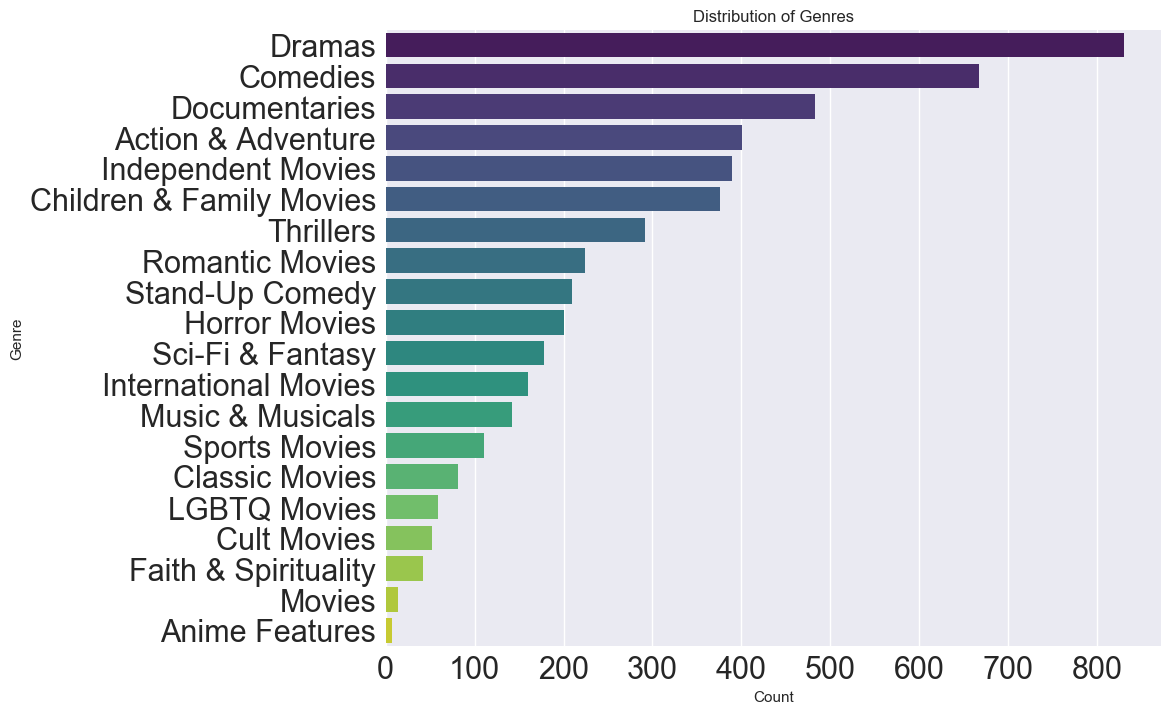

In [192]:
# Analyze the distribution of genres
genre_distribution = usa.explode('categories')['categories'].value_counts()

print(genre_distribution)

# Plot the distribution of genres
plt.figure(figsize=(10, 8))
sns.barplot(y=genre_distribution.index, x=genre_distribution.values, palette='viridis')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.yticks(fontsize=22) 
plt.xticks(fontsize=22) 
plt.show()

                        Genre Combination  Count
0            (Dramas, Independent Movies)    280
1    (Children & Family Movies, Comedies)    189
2                      (Dramas, Comedies)    145
3                     (Dramas, Thrillers)    121
4          (Independent Movies, Comedies)    117
5             (Romantic Movies, Comedies)    116
6               (Dramas, Romantic Movies)    116
7  (Action & Adventure, Sci-Fi & Fantasy)    104
8              (Horror Movies, Thrillers)     79
9          (Action & Adventure, Comedies)     77


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


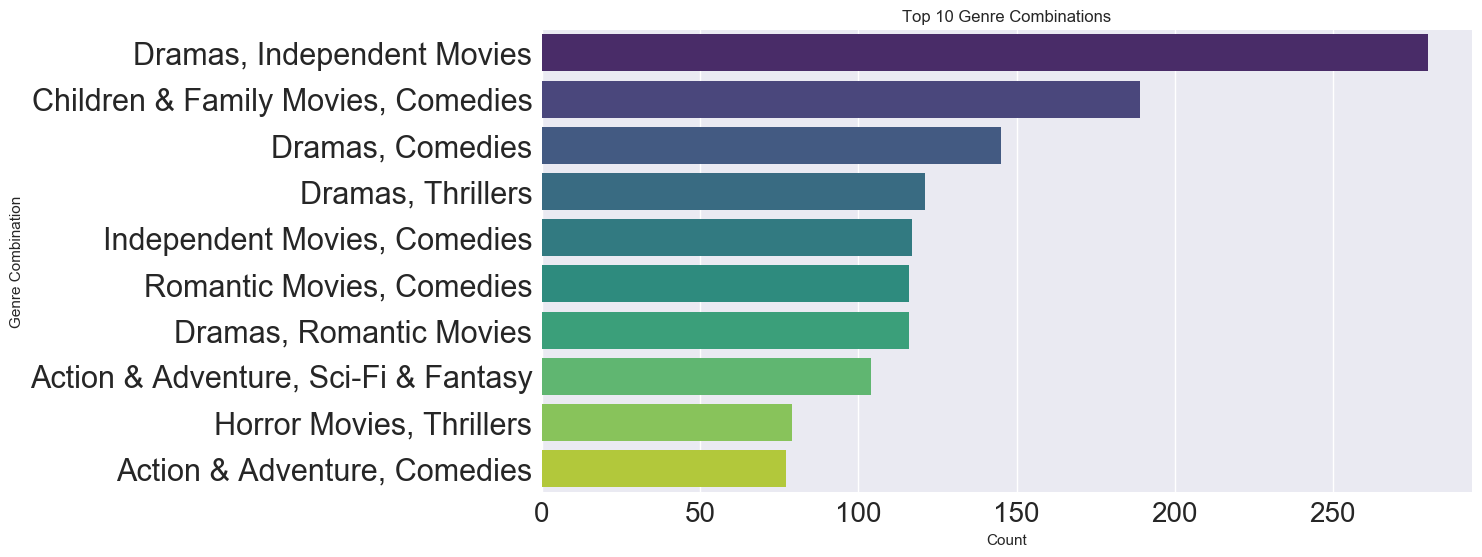

In [193]:
# Explore common genre combinations and their prevalence
def count_genre_combinations(genres_list):
    combo_counter = Counter()
    for genres in genres_list:
        # Generate all combinations of genres
        for combo_length in range(2, len(genres) + 1):
            for combo in combinations(genres, combo_length):
                combo_counter[frozenset(combo)] += 1
    return combo_counter

# Count genre combinations
genre_combinations = count_genre_combinations(usa['categories'])

# Convert to DataFrame for easier analysis
genre_combinations_df = pd.DataFrame(genre_combinations.items(), columns=['Genre Combination', 'Count'])
genre_combinations_df = genre_combinations_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

print(genre_combinations_df.head(10))  # Display the top 10 genre combinations

# Plot the top 10 genre combinations
top_n = 10
top_combinations = genre_combinations_df.head(top_n)
top_combinations['Genre Combination'] = top_combinations['Genre Combination'].apply(lambda x: ', '.join(x))

plt.figure(figsize=(12, 6))
sns.barplot(y=top_combinations['Genre Combination'], x=top_combinations['Count'], palette='viridis')
plt.title('Top 10 Genre Combinations')
plt.xlabel('Count')
plt.ylabel('Genre Combination')
plt.yticks(fontsize=22) 
plt.xticks(fontsize=20) 
plt.show()


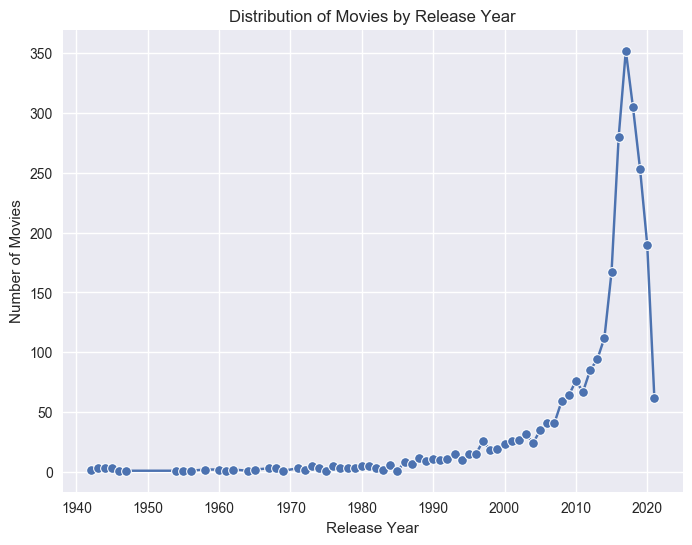

In [19]:
# Analyze the distribution of movies by release year
release_year_distribution = usa['release_year'].value_counts().sort_index()

# Plot the distribution of movies by release year
plt.figure(figsize=(8, 6))
sns.lineplot(x=release_year_distribution.index, y=release_year_distribution.values, marker='o')
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

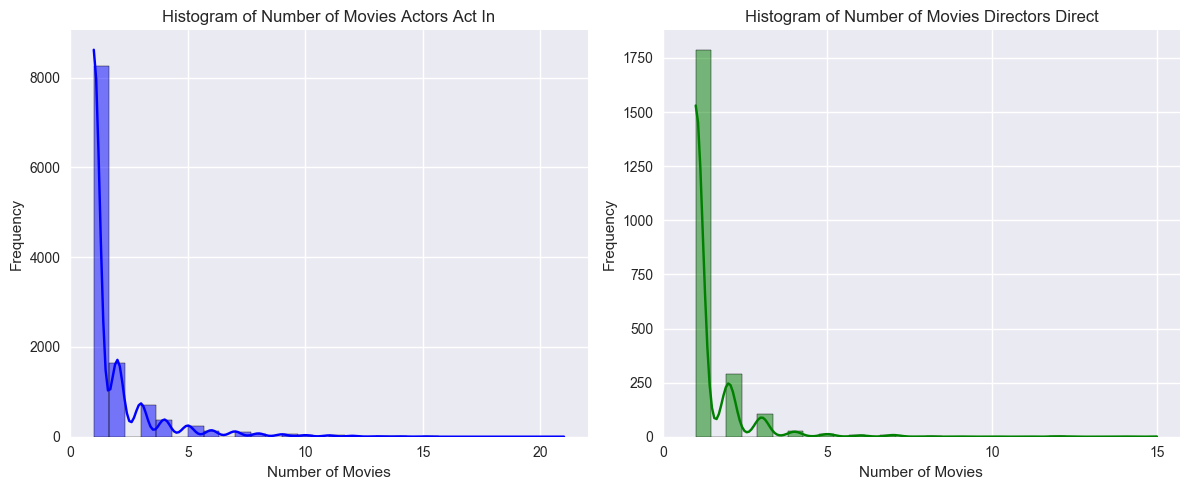

In [66]:
usa_exploded_act = usa.explode('actors')
usa_exploded_dir = usa.explode('directors')

# Count the frequency of each actor and director
actor_counter = Counter(usa_exploded_act['actors'])
director_counter = Counter(usa_exploded_dir['directors'])

# Convert counters to DataFrames for plotting
actor_df = pd.DataFrame(actor_counter.items(), columns=['Actor', 'Count'])
actor_df = actor_df.dropna(subset=['Actor'])
director_df = pd.DataFrame(director_counter.items(), columns=['Director', 'Count'])
director_df = director_df.dropna(subset=['Director'])

# Plot histogram for actors
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(actor_df['Count'], bins=30, kde=True, color='blue')
plt.title('Histogram of Number of Movies Actors Act In')
plt.xlabel('Number of Movies')
plt.ylabel('Frequency')
plt.xticks(range(0, actor_df['Count'].max() + 1, 5))  # Adjust the x-ticks as needed

# Plot histogram for directors
plt.subplot(1, 2, 2)
sns.histplot(director_df['Count'], bins=30, kde=True, color='green')
plt.title('Histogram of Number of Movies Directors Direct')
plt.xlabel('Number of Movies')
plt.ylabel('Frequency')
plt.xticks(range(0, director_df['Count'].max() + 1, 5))  # Adjust the x-ticks as needed

plt.tight_layout()
plt.show()


In [51]:
director_df.sort_values(['Count'], ascending=False).head(5)

Director  Count
649         Jay Karas     15
682      Marcus Raboy     14
363   Martin Scorsese     12
841       Jay Chapman     12
7    Steven Spielberg     11

In [50]:
actor_df.sort_values(['Count'], ascending=False).head(5)

Actor  Count
273   Samuel L. Jackson     21
20         Adam Sandler     20
558        James Franco     19
2542       Nicolas Cage     18
180      Morgan Freeman     15

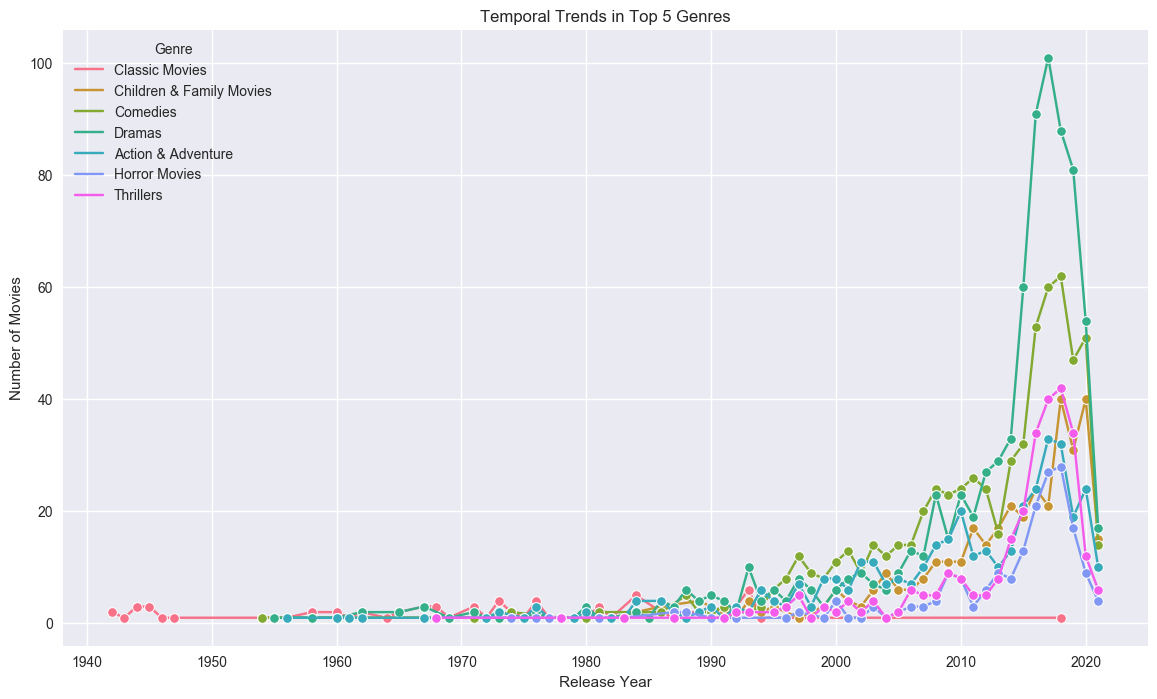

In [24]:
# Split genres into separate rows
usa_exploded_genre = usa.explode('categories')

# Group by release year and genre, then count the occurrences
genre_trends = usa_exploded_genre.groupby(['release_year', 'categories']).size().reset_index(name='count')

# Plot the temporal trends for the top 5 genres
top_genres = genre_trends['categories'].value_counts().head(7).index
top_genres_trends = genre_trends[genre_trends['categories'].isin(top_genres)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=top_genres_trends, x='release_year', y='count', hue='categories', marker='o')
plt.title('Temporal Trends in Top 5 Genres')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genre')
plt.grid(True)
plt.show()


## Create graphs

In [53]:
def create_graph_from_df(df):
    # Initialize graph
    G = nx.Graph()

    for _, row in df.iterrows():
        directors = row['directors']
        actors = row['actors']
        categories = row['categories']

        for director in directors:
          G.add_node(director + '_d', type='director', category=categories)

        for actor in actors:
          G.add_node(actor + '_a', type='actor', category=categories)
          G.add_edge(director + '_d', actor + '_a')

        # Add edges between actors in the same project
        for i in range(len(actors)):
            for j in range(i + 1, len(actors)):
                G.add_edge(actors[i] + '_a', actors[j] + '_a')

        # Add edges between directors in the same project
        for i in range(len(directors)):
            for j in range(i + 1, len(directors)):
                G.add_edge(directors[i] + '_d', directors[j] + '_d')


     # Add edges between directors and actors only if there are more than 2 actors and directors
        if len(actors) > 2 and len(directors) > 2:
          for director in directors:
            for actor in actors:
              G.add_edge(director + '_d', actor + '_a')


    # Ensure that all nodes have the 'type' attribute
    for node in G.nodes:
        if 'type' not in G.nodes[node]:
            G.nodes[node]['type'] = 'unknown'

    print("Graph created")
    print("number of nodes: ", G.number_of_nodes())
    print("number of edges: ",G.number_of_edges())

    return G


In [54]:
# Initialize full graph
full_graph = create_graph_from_df(usa)

Graph created
number of nodes:  13932
number of edges:  116403


In [ ]:
def visualize_collaborations(node):
    if node in full_graph:
        neighbors = list(full_graph.neighbors(node))

        # Create a subgraph containing the queried node and its neighbors
        subgraph = full_graph.subgraph([node] + neighbors)

        plt.figure(figsize=(10, 6))

        # Draw the subgraph
        pos = nx.spring_layout(subgraph)  # Positions of the nodes
        labels = {n: n for n in subgraph.nodes()}  # Labels for all nodes

        # Set the color for the main node and its neighbors based on their type
        node_colors = ['red' if subgraph.nodes[n]['type'] == 'director' else 'blue' for n in subgraph.nodes()]

        # Draw the subgraph with node labels
        nx.draw(subgraph, pos=pos, with_labels=True, labels=labels, node_color=node_colors, edge_color="gray", node_size=50, font_size=10)

        # Create legend entries
        legend_labels = ["Director", "Actors"]

        # Create legend colors
        legend_colors = ["red", "blue"]

        # Create custom legend elements
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=5)
                           for label, color in zip(legend_labels, legend_colors)]

        # Create legend
        plt.legend(handles=legend_elements, loc="upper right", facecolor="white", framealpha=1)

        # Display the graph
        plt.title(f'Collaboration Graph for {node}')
        plt.show()
    else:
        print(f'Node "{node}" not found in the graph.')

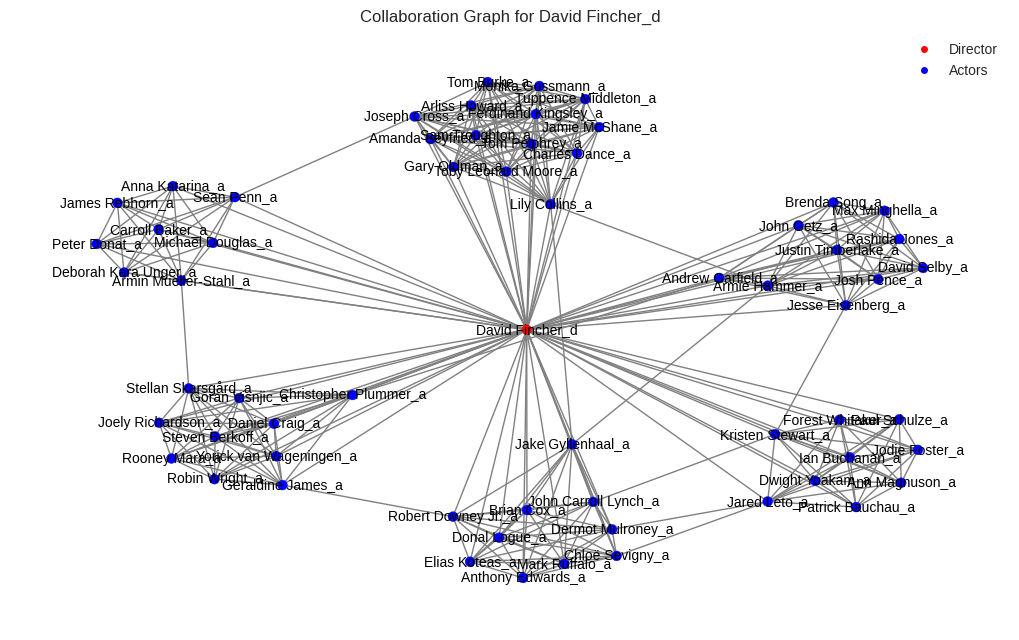

In [ ]:
visualize_collaborations("David Fincher_d")

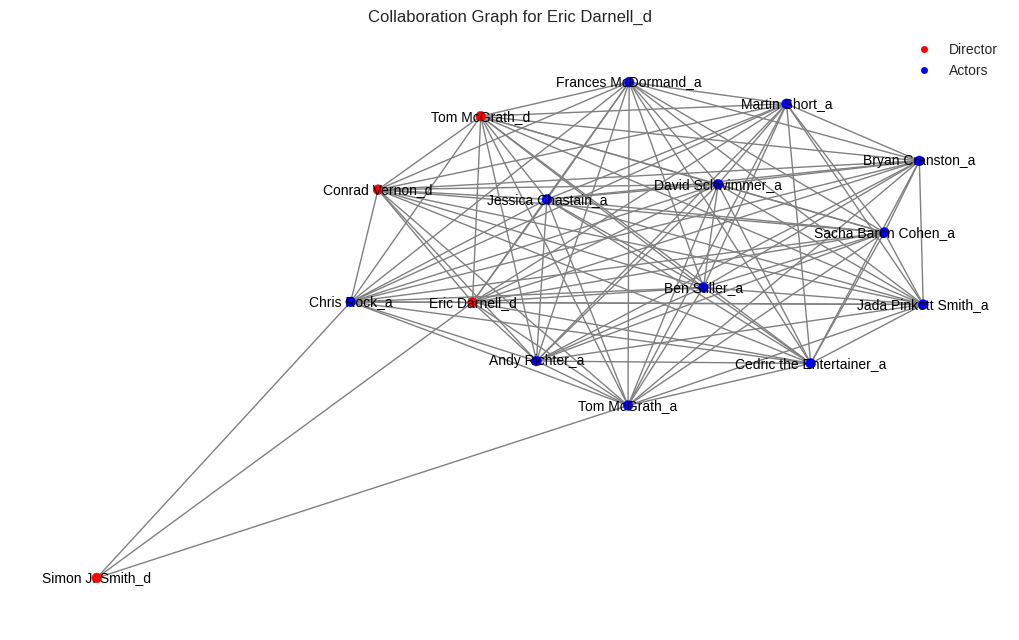

In [ ]:
visualize_collaborations("Eric Darnell_d")

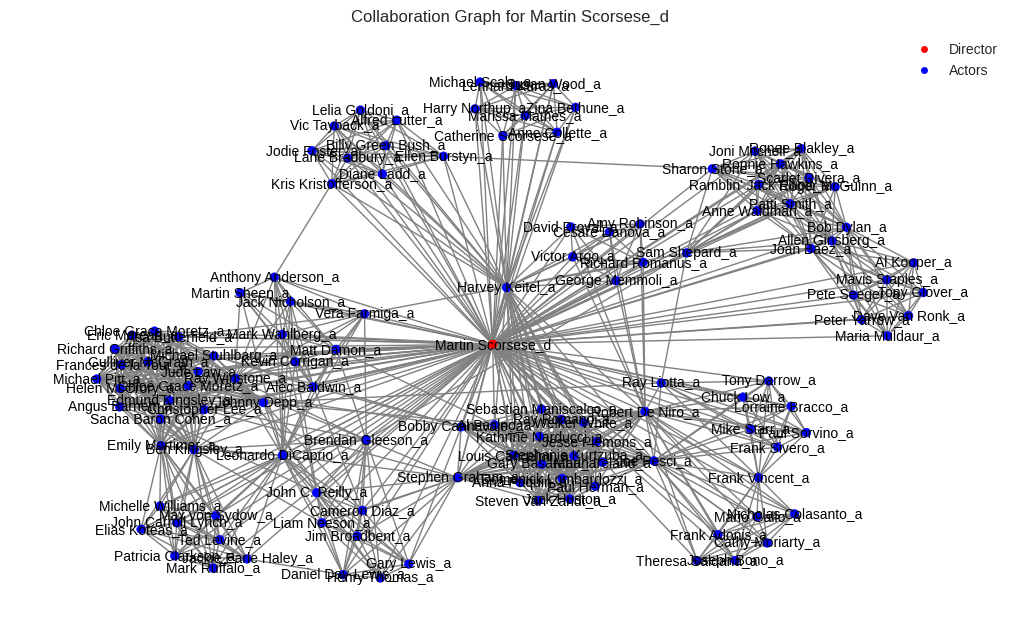

In [ ]:
visualize_collaborations("Martin Scorsese_d")

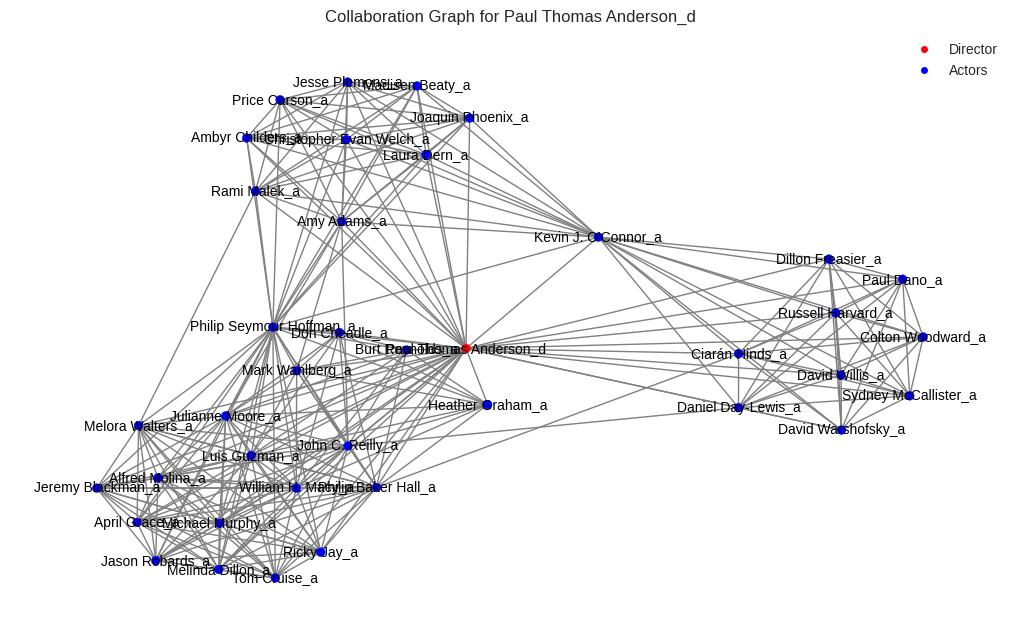

In [ ]:
visualize_collaborations("Paul Thomas Anderson_d")

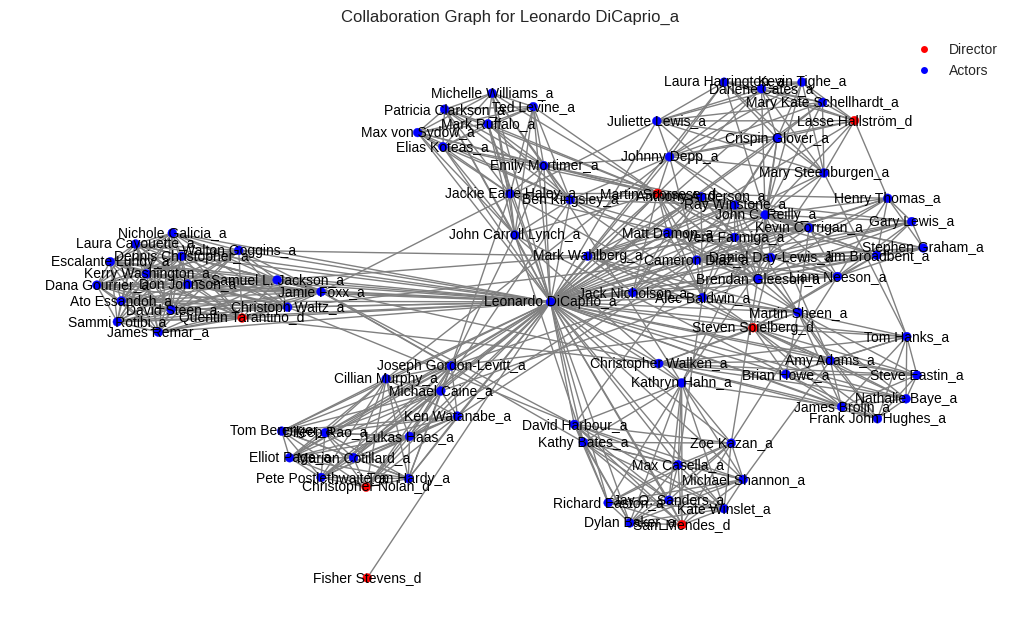

In [ ]:
visualize_collaborations("Leonardo DiCaprio_a")

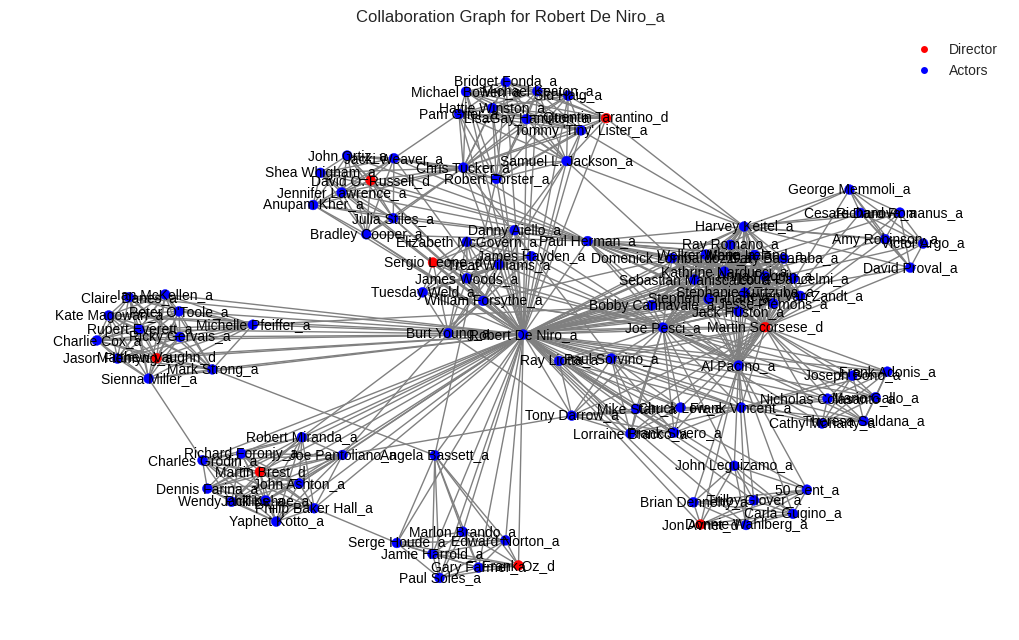

In [ ]:
visualize_collaborations("Robert De Niro_a")

In [127]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(full_graph)
betweenness_centrality = nx.betweenness_centrality(full_graph)
closeness_centrality = nx.closeness_centrality(full_graph)

# Create a DataFrame to store centrality measures
centrality_df = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality': closeness_centrality
})

# Find the top 10 nodes based on degree centrality
top_10 = centrality_df.sort_values('degree_centrality', ascending=False).head(10)


KeyboardInterrupt: 

In [ ]:
degree_centrality = nx.degree_centrality(full_graph)

In [130]:
centrality_df = pd.read_csv("centrality_netflix.csv", index_col=0)
centrality_df

degree_centrality  betweenness_centrality  \
Kirsten Johnson_d               0.000000                     0.0   
Haile Gerima_d                  0.000574                     0.0   
Kofi Ghanaba_a                  0.000574                     0.0   
Oyafunmike Ogunlano_a           0.000574                     0.0   
Alexandra Duah_a                0.000574                     0.0   
...                                  ...                     ...   
Bridger Palmer_a                0.000718                     0.0   
Ty Panitz_a                     0.000718                     0.0   
Derek Graf_a                    0.000502                     0.0   
Peter Hewitt_d                  0.000646                     0.0   
Ryan Newman_a                   0.000646                     0.0   

                       closeness_centrality  
Kirsten Johnson_d                  0.000000  
Haile Gerima_d                     0.000574  
Kofi Ghanaba_a                     0.000574  
Oyafunmike Ogunlano_a              0.000574  
Alexandra Duah_a                   0.000574  
...                                     ...  
Bridger Palmer_a                   0.239125  
Ty Panitz_a                        0.239125  
Derek Graf_a                       0.250610  
Peter Hewitt_d                     0.232438  
Ryan Newman_a                      0.232438  

[13932 rows x 3 columns]

In [136]:
centrality_df_director

NameError: name 'centrality_df_director' is not defined

In [135]:
centrality_df.loc["Scott Stewart_d"]

degree_centrality         0.002800
betweenness_centrality    0.000429
closeness_centrality      0.257342
Name: Scott Stewart_d, dtype: float64

In [ ]:
all_directors = [node for node, attr in full_graph.nodes(data=True) if attr['type'] == 'director']
all_actors = [node for node, attr in full_graph.nodes(data=True) if attr['type'] == 'actor']

# Print the number of directors
print("Number of directors:", len(all_directors))
print("Number of actors:", len(all_actors))

Number of directors: 2246
Number of actors: 11686


In [ ]:
director_centrality_df = centrality_df.loc[all_directors]
director_centrality_df.sort_values("degree_centrality", ascending=False).head(10)

degree_centrality  betweenness_centrality  \
Martin Scorsese_d             0.008686                0.003644   
Steven Spielberg_d            0.008255                0.004078   
Steve Brill_d                 0.006532                0.001288   
Don Michael Paul_d            0.005599                0.002839   
Robert Rodriguez_d            0.005312                0.002540   
Steve Carr_d                  0.005240                0.000831   
Quentin Tarantino_d           0.005097                0.001518   
McG_d                         0.005097                0.001752   
Clint Eastwood_d              0.005025                0.001604   
Lasse Hallström_d             0.004809                0.000930   

                     closeness_centrality  
Martin Scorsese_d                0.295068  
Steven Spielberg_d               0.289144  
Steve Brill_d                    0.299297  
Don Michael Paul_d               0.266551  
Robert Rodriguez_d               0.283395  
Steve Carr_d                     0.294407  
Quentin Tarantino_d              0.289804  
McG_d                            0.287570  
Clint Eastwood_d                 0.271711  
Lasse Hallström_d                0.276700

In [ ]:
actor_centrality_df = centrality_df.loc[all_actors]
actor_centrality_df.sort_values("degree_centrality", ascending=False).head(10)

degree_centrality  betweenness_centrality  \
James Franco_a                0.015720                0.012072   
Samuel L. Jackson_a           0.015433                0.015536   
Dennis Quaid_a                0.013208                0.009845   
Adam Sandler_a                0.013064                0.005847   
Liev Schreiber_a              0.012993                0.007913   
Nicolas Cage_a                0.012705                0.010772   
Terrence Howard_a             0.012562                0.008555   
Fred Armisen_a                0.012347                0.004600   
Willem Dafoe_a                0.012275                0.007559   
Maya Rudolph_a                0.011844                0.005053   

                     closeness_centrality  
James Franco_a                   0.312338  
Samuel L. Jackson_a              0.319207  
Dennis Quaid_a                   0.309711  
Adam Sandler_a                   0.304890  
Liev Schreiber_a                 0.314813  
Nicolas Cage_a                   0.307993  
Terrence Howard_a                0.312250  
Fred Armisen_a                   0.297676  
Willem Dafoe_a                   0.303433  
Maya Rudolph_a                   0.306242

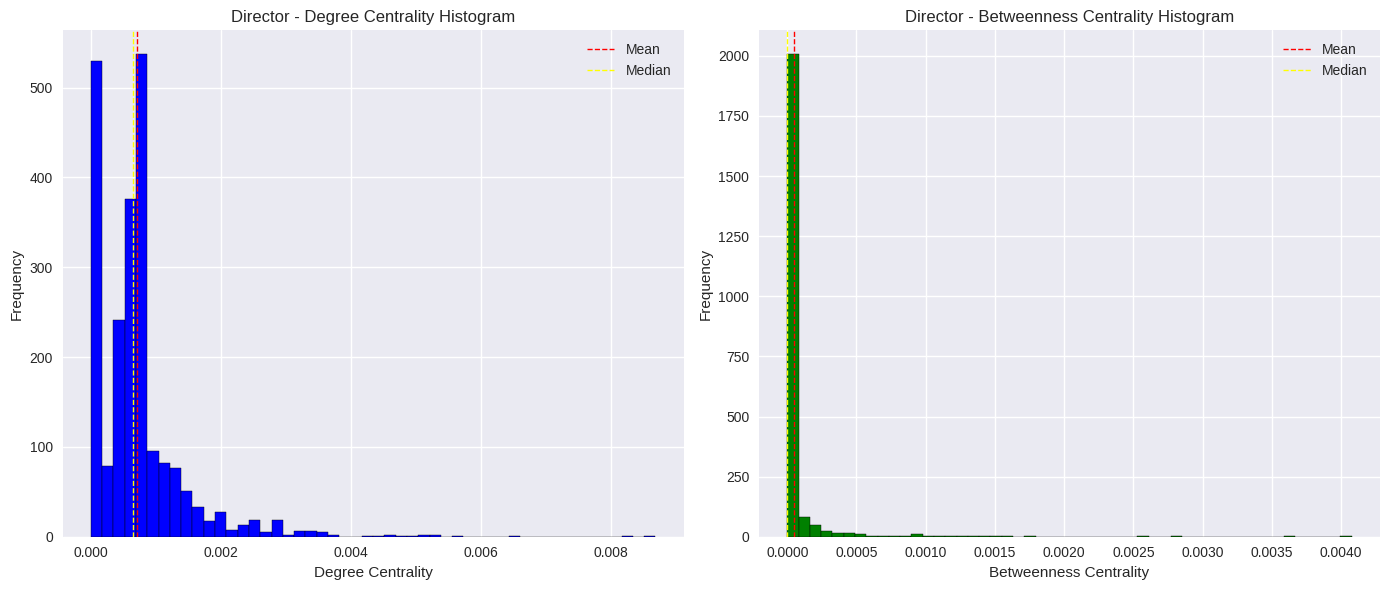

In [ ]:
# Create histograms for degree centrality and betweenness centrality
plt.figure(figsize=(14, 6))

# Degree Centrality
plt.subplot(1, 2, 1)
plt.hist(director_centrality_df['degree_centrality'], bins=50, color='blue', edgecolor='black')
plt.axvline(director_centrality_df['degree_centrality'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(director_centrality_df['degree_centrality'].median(), color='yellow', linestyle='dashed', linewidth=1, label='Median')
plt.title('Director - Degree Centrality Histogram')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend()

# Betweenness Centrality
plt.subplot(1, 2, 2)
plt.hist(director_centrality_df['betweenness_centrality'], bins=50, color='green', edgecolor='black')
plt.axvline(director_centrality_df['betweenness_centrality'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(director_centrality_df['betweenness_centrality'].median(), color='yellow', linestyle='dashed', linewidth=1, label='Median')
plt.title('Director - Betweenness Centrality Histogram')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

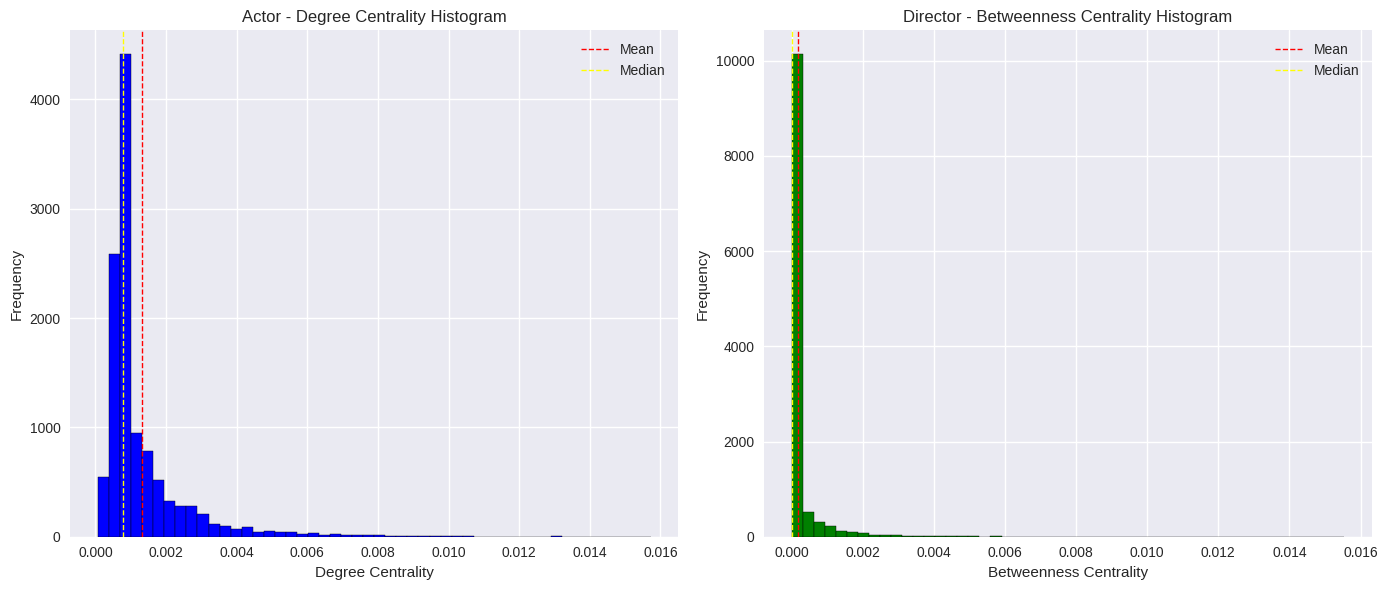

In [ ]:
# Create histograms for degree centrality and betweenness centrality
plt.figure(figsize=(14, 6))

# Degree Centrality
plt.subplot(1, 2, 1)
plt.hist(actor_centrality_df['degree_centrality'], bins=50, color='blue', edgecolor='black')
plt.axvline(actor_centrality_df['degree_centrality'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(actor_centrality_df['degree_centrality'].median(), color='yellow', linestyle='dashed', linewidth=1, label='Median')
plt.title('Actor - Degree Centrality Histogram')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend()

# Betweenness Centrality
plt.subplot(1, 2, 2)
plt.hist(actor_centrality_df['betweenness_centrality'], bins=50, color='green', edgecolor='black')
plt.axvline(actor_centrality_df['betweenness_centrality'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(actor_centrality_df['betweenness_centrality'].median(), color='yellow', linestyle='dashed', linewidth=1, label='Median')
plt.title('Director - Betweenness Centrality Histogram')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

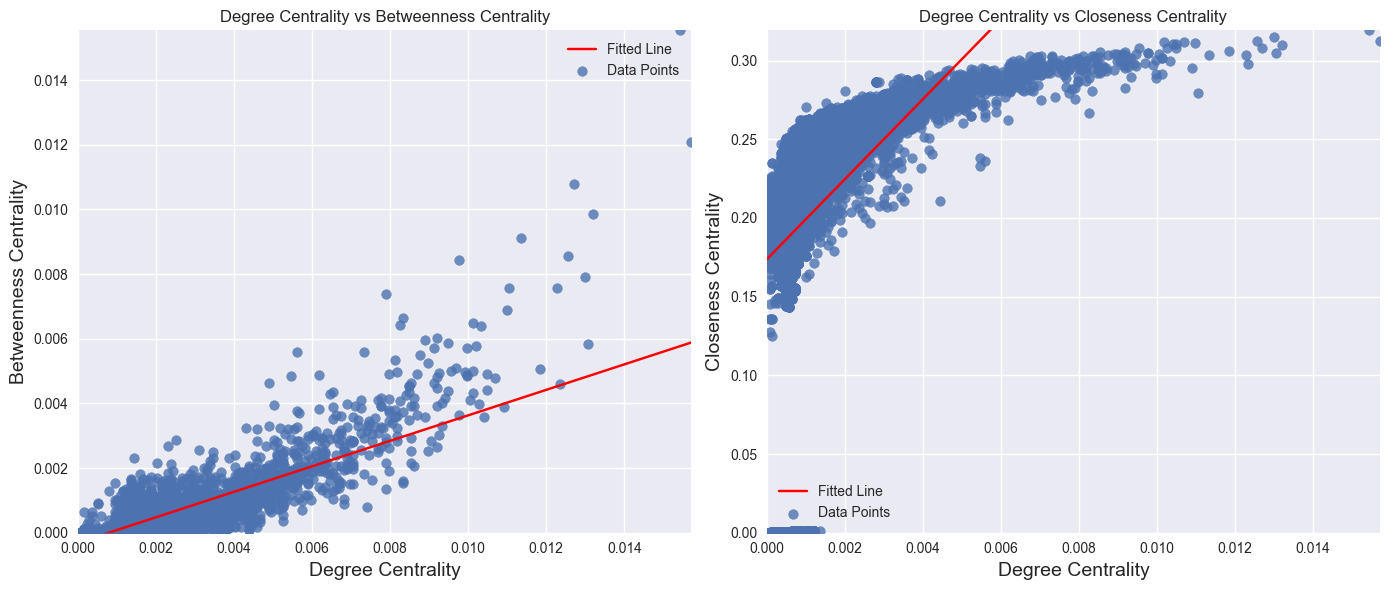

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
x1 = centrality_df.degree_centrality
y1 = centrality_df.betweenness_centrality
x2 = centrality_df.degree_centrality
y2 = centrality_df.closeness_centrality

# Fit a linear regression line with intercept forced to be 0 for the first plot
coefficients1 = np.polyfit(x1, y1, 1)
poly_function1 = np.poly1d(coefficients1)
x_values1 = np.linspace(min(x1), max(x1), 100)
y_values1 = poly_function1(x_values1)

# Fit a linear regression line with intercept forced to be 0 for the second plot
coefficients2 = np.polyfit(x2, y2, 1)
poly_function2 = np.poly1d(coefficients2)
x_values2 = np.linspace(min(x2), max(x2), 100)
y_values2 = poly_function2(x_values2)

# Plot both scatter plots and the fitted lines
plt.figure(figsize=(14, 6))

# Degree centrality vs Betweenness centrality
plt.subplot(1, 2, 1)
plt.scatter(x1, y1, alpha=0.8, label='Data Points')
plt.plot(x_values1, y_values1, color='red', label='Fitted Line')
plt.xlabel('Degree Centrality', fontsize=14)
plt.ylabel('Betweenness Centrality', fontsize=14)
plt.legend()
plt.title('Degree Centrality vs Betweenness Centrality')
plt.axis([0, max(x1), 0, max(y1)])  # Set axis limits to start at 0

# Degree centrality vs Closeness centrality
plt.subplot(1, 2, 2)
plt.scatter(x2, y2, alpha=0.8, label='Data Points')
plt.plot(x_values2, y_values2, color='red', label='Fitted Line')
plt.xlabel('Degree Centrality', fontsize=14)
plt.ylabel('Closeness Centrality', fontsize=14)
plt.legend()
plt.title('Degree Centrality vs Closeness Centrality')
plt.axis([0, max(x2), 0, max(y2)])  # Set axis limits to start at 0

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
category = []
for _, row in usa.iterrows():
    categories = row['categories']
    for value in categories:
        category += [value]

np.unique(category)

array(['Action & Adventure', 'Anime Features', 'Children & Family Movies',
       'Classic Movies', 'Comedies', 'Cult Movies', 'Documentaries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'International Movies', 'LGBTQ Movies',
       'Movies', 'Music & Musicals', 'Romantic Movies',
       'Sci-Fi & Fantasy', 'Sports Movies', 'Stand-Up Comedy',
       'Thrillers'], dtype='<U24')

In [ ]:
from collections import Counter
Counter(category)

Counter({'Documentaries': 483,
         'Dramas': 830,
         'Independent Movies': 389,
         'International Movies': 160,
         'Comedies': 667,
         'Horror Movies': 201,
         'Sci-Fi & Fantasy': 178,
         'Thrillers': 292,
         'Action & Adventure': 401,
         'Classic Movies': 81,
         'Children & Family Movies': 376,
         'Music & Musicals': 142,
         'Sports Movies': 111,
         'Cult Movies': 52,
         'Romantic Movies': 224,
         'Faith & Spirituality': 42,
         'LGBTQ Movies': 59,
         'Anime Features': 7,
         'Movies': 14,
         'Stand-Up Comedy': 209})

In [147]:
drama_df = usa[usa['categories'].apply(lambda x: 'Dramas' in x)]
docu_df = usa[usa['categories'].apply(lambda x: 'Documentaries' in x)]
comedy_df = usa[usa['categories'].apply(lambda x: 'Comedies' in x)]
horror_df = usa[usa['categories'].apply(lambda x: 'Horror Movies' in x)]
children_df = usa[usa['categories'].apply(lambda x: 'Children & Family Movies' in x)]
action_df = usa[usa['categories'].apply(lambda x: 'Action & Adventure' in x)]

In [169]:
def calculate_cast_lengths(df):
    # Function to calculate the length of the list
    def count_cast(cast_list):
        return len(cast_list)

    # Apply the function to the 'actors' column and store the result in a new column 'cast_num'
    df['cast_num'] = df['actors'].apply(count_cast)

    # Apply the function to the 'directors' column and store the result in a new column 'director_num'
    df['director_num'] = df['directors'].apply(count_cast)
    
    return df

In [171]:
calculate_cast_lengths(usa)
calculate_cast_lengths(drama_df)
calculate_cast_lengths(docu_df)
calculate_cast_lengths(comedy_df)
calculate_cast_lengths(horror_df)
calculate_cast_lengths(children_df)
calculate_cast_lengths(action_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


show_id   type                          title          director  \
38       s39  Movie            Birth of the Dragon      George Nolfi   
41       s42  Movie                           Jaws  Steven Spielberg   
43       s44  Movie                         Jaws 3         Joe Alves   
44       s45  Movie              Jaws: The Revenge    Joseph Sargent   
46       s47  Movie                     Safe House   Daniel Espinosa   
...      ...    ...                            ...               ...   
8757   s8758  Movie             World Trade Center      Oliver Stone   
8764   s8765  Movie                     Wyatt Earp   Lawrence Kasdan   
8766   s8767  Movie                            XXx         Rob Cohen   
8767   s8768  Movie        XXX: State of the Union      Lee Tamahori   
8790   s8791  Movie  You Don't Mess with the Zohan      Dennis Dugan   

                                                   cast  \
38    Billy Magnussen, Ron Yuan, Qu Jingjing, Terry ...   
41    Roy Scheider, Robert Shaw, Richard Dreyfuss, L...   
43    Dennis Quaid, Bess Armstrong, Simon MacCorkind...   
44    Lorraine Gary, Lance Guest, Mario Van Peebles,...   
46    Denzel Washington, Ryan Reynolds, Vera Farmiga...   
...                                                 ...   
8757  Nicolas Cage, Michael Peña, Maggie Gyllenhaal,...   
8764  Kevin Costner, Dennis Quaid, Gene Hackman, Dav...   
8766  Vin Diesel, Asia Argento, Marton Csokas, Samue...   
8767  Ice Cube, Samuel L. Jackson, Willem Dafoe, Sco...   
8790  Adam Sandler, John Turturro, Emmanuelle Chriqu...   

                                 country date_added  release_year rating  \
38          China, Canada, United States 2021-09-16          2017  PG-13   
41                         United States 2021-09-16          1975     PG   
43                         United States 2021-09-16          1983     PG   
44                         United States 2021-09-16          1987  PG-13   
46    South Africa, United States, Japan 2021-09-16          2012      R   
...                                  ...        ...           ...    ...   
8757                       United States 2019-11-20          2006  PG-13   
8764                       United States 2020-01-01          1994  PG-13   
8766                       United States 2019-01-01          2002  PG-13   
8767                       United States 2019-01-01          2005  PG-13   
8790                       United States 2019-09-01          2008     UR   

     duration  ...                                        description    year  \
38     96 min  ...  A young Bruce Lee angers kung fu traditionalis...  2021.0   
41    124 min  ...  When an insatiable great white shark terrorize...  2021.0   
43     98 min  ...  After the staff of a marine theme park try to ...  2021.0   
44     91 min  ...  After another deadly shark attack, Ellen Brody...  2021.0   
46    115 min  ...  Young CIA operative Matt Weston must get a dan...  2021.0   
...       ...  ...                                                ...     ...   
8757  129 min  ...  Working under treacherous conditions, an army ...  2019.0   
8764  191 min  ...  Legendary lawman Wyatt Earp is continually at ...  2020.0   
8766  124 min  ...  A notorious underground rush-seeker deemed unt...  2019.0   
8767  101 min  ...  In this action-packed follow-up to XXX, U.S. i...  2019.0   
8790  113 min  ...  An Israeli counterterrorism soldier with a sec...  2019.0   

      month   day           directors                             countries  \
38      9.0  16.0      [George Nolfi]        [China, Canada, United States]   
41      9.0  16.0  [Steven Spielberg]                       [United States]   
43      9.0  16.0         [Joe Alves]                       [United States]   
44      9.0  16.0    [Joseph Sargent]                       [United States]   
46      9.0  16.0   [Daniel Espinosa]  [South Africa, United States, Japan]   
...     ...   ...                 ...                                  

In [176]:
def print_average_cast_num(names, *dfs):
    for name, df in zip(names, dfs):
        avg_cast_num = df['cast_num'].mean()
        print(f"Average cast number in {name}: {avg_cast_num:.2f}")

# Example usage:
names = ['All', 'Drama', 'Documentary', 'Comedy', 'Horror', 'Children', 'Action']
print_average_cast_num(names, usa, drama_df, docu_df, comedy_df, horror_df, children_df, action_df)


Average cast number in All: 7.52
Average cast number in Drama: 9.35
Average cast number in Documentary: 1.50
Average cast number in Comedy: 10.31
Average cast number in Horror: 9.11
Average cast number in Children: 9.88
Average cast number in Action: 10.27


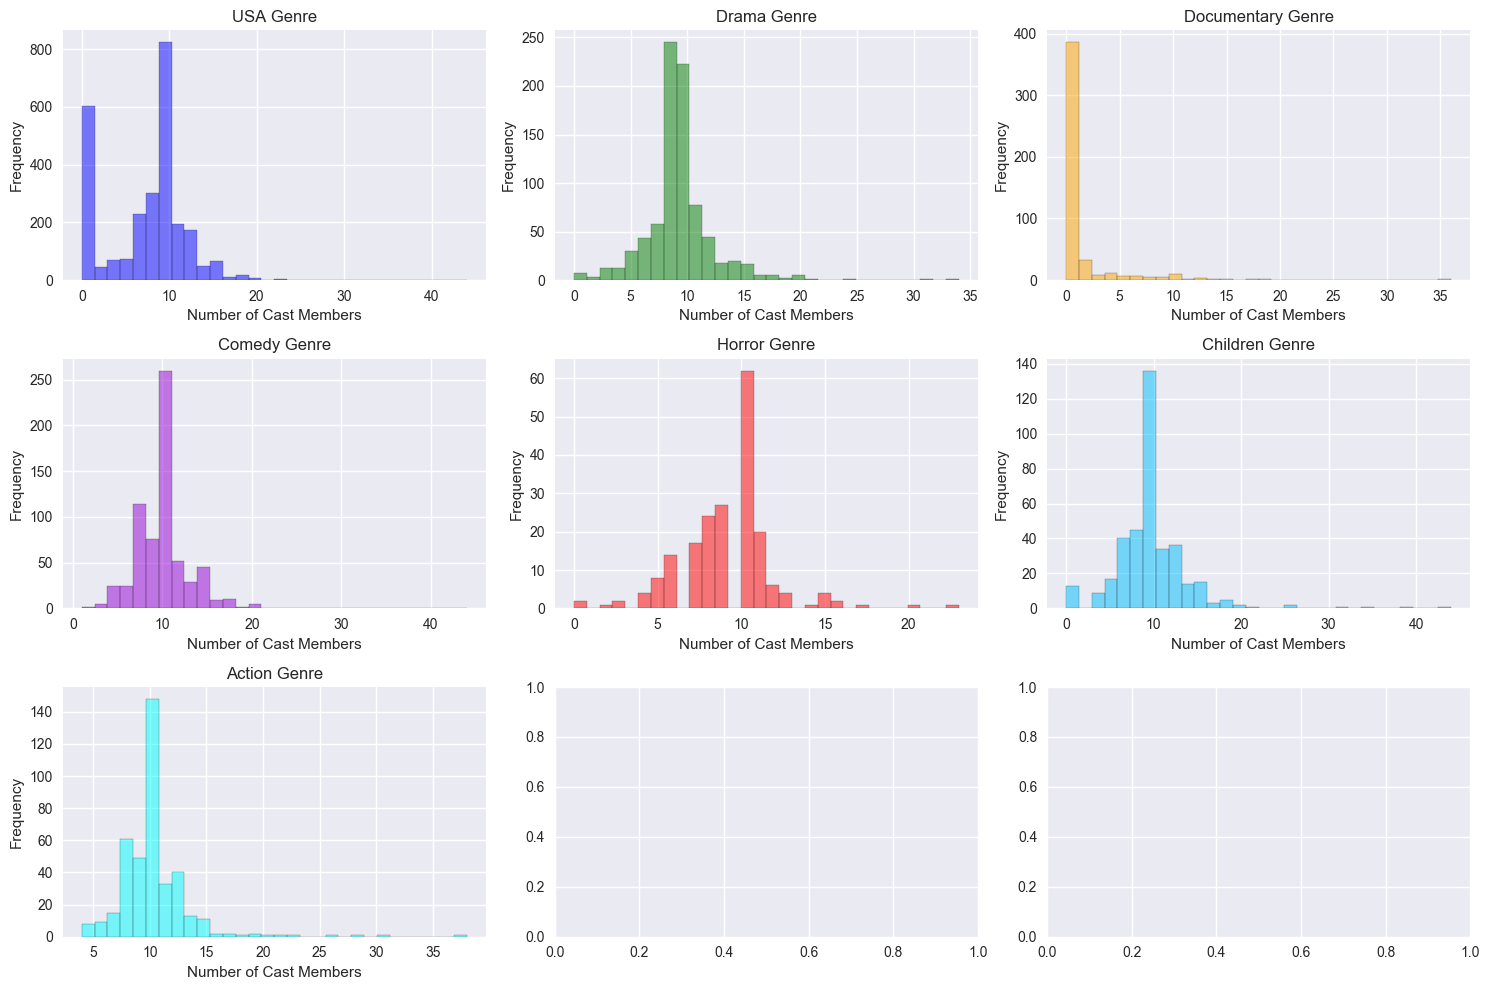

In [178]:
import matplotlib.pyplot as plt

def plot_cast_num_histograms_subplot(*dfs):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    colors = ['blue', 'green', 'orange', 'darkviolet', 'red', 'deepskyblue', 'cyan']
    labels = ['USA', 'Drama', 'Documentary', 'Comedy', 'Horror', 'Children', 'Action']
    
    for i, df in enumerate(dfs):
        ax = axs[i//3, i%3]
        ax.hist(df['cast_num'], bins=30, alpha=0.5, color=colors[i], edgecolor='black')
        ax.set_title(f'{labels[i]} Genre')
        ax.set_xlabel('Number of Cast Members')
        ax.set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Example usage
plot_cast_num_histograms_subplot(usa, drama_df, docu_df, comedy_df, horror_df, children_df, action_df)


In [148]:
# Create graph for each genre

drama_graph = create_graph_from_df(drama_df)
docu_graph = create_graph_from_df(docu_df)
comedy_graph = create_graph_from_df(comedy_df)
horror_graph = create_graph_from_df(horror_df)
children_graph = create_graph_from_df(children_df)
action_graph = create_graph_from_df(action_df)

Graph created
number of nodes:  6254
number of edges:  43588
Graph created
number of nodes:  1190
number of edges:  3405
Graph created
number of nodes:  5114
number of edges:  43139
Graph created
number of nodes:  1840
number of edges:  10154
Graph created
number of nodes:  3085
number of edges:  23281
Graph created
number of nodes:  3410
number of edges:  24879


In [78]:
def calculate_centrality_measures(graph):
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Create a DataFrame to store centrality measures
    centrality_df = pd.DataFrame({
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality
    })

    return centrality_df


def filter_actors(df):
    # Filter the DataFrame to include only rows where the index ends with '_a'
    actor_centrality_df = df.loc[df.index.str.endswith('_a')]
    return actor_centrality_df

def filter_directors(df):
    # Filter the DataFrame to include only rows where the index ends with '_d'
    director_centrality_df = df.loc[df.index.str.endswith('_d')]
    return director_centrality_df

In [ ]:
drama_centrality_df = calculate_centrality_measures(drama_graph)
drama_centrality_df.to_csv("drama_centrality_df")

In [ ]:
docu_centrality_df = calculate_centrality_measures(docu_graph)
docu_centrality_df.to_csv("docu_centrality_df")
comedy_centrality_df = calculate_centrality_measures(comedy_graph)
comedy_centrality_df.to_csv("comedy_centrality_df")
horror_centrality_df = calculate_centrality_measures(horror_graph)
horror_centrality_df.to_csv("horror_centrality_df")
children_centrality_df = calculate_centrality_measures(children_graph)
children_centrality_df.to_csv("children_centrality_df")
action_centrality_df = calculate_centrality_measures(action_graph)
action_centrality_df.to_csv("action_centrality_df")

In [ ]:
def calculate_mean_median_across_genres(*dfs):
    # Concatenate all DataFrames into one
    combined_df = pd.concat(dfs, keys=['all', 'drama', 'docu', 'comedy', 'horror', 'children', 'action'], names=['genre', 'index'])

    # Calculate mean and median values across all genres
    mean_values = combined_df.groupby('genre').mean()
    median_values = combined_df.groupby('genre').median()

    # Combine mean and median into a single DataFrame
    mean_median_df = pd.concat([mean_values, median_values], keys=['mean', 'median'])

    return mean_median_df

In [92]:
centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/centrality_netflix.csv", index_col=0)
drama_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/drama_centrality_df", index_col=0)
docu_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/docu_centrality_df", index_col=0)
comedy_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/comedy_centrality_df", index_col=0)
horror_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/horror_centrality_df", index_col=0)
children_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/children_centrality_df", index_col=0)
action_centrality_df = pd.read_csv("https://raw.githubusercontent.com/aphdinh/socialnetwork/main/action_centrality_df", index_col=0)

In [79]:
# Filter for directors
all_directors_df = filter_directors(centrality_df)
drama_directors_df = filter_directors(drama_centrality_df)
docu_directors_df = filter_directors(docu_centrality_df)
comedy_directors_df = filter_directors(comedy_centrality_df)
horror_directors_df = filter_directors(horror_centrality_df)
children_directors_df = filter_directors(children_centrality_df)
action_directors_df = filter_directors(action_centrality_df)

# Filter for actors
all_actors_df = filter_actors(centrality_df)
drama_actors_df = filter_actors(drama_centrality_df)
docu_actors_df = filter_actors(docu_centrality_df)
comedy_actors_df = filter_actors(comedy_centrality_df)
horror_actors_df = filter_actors(horror_centrality_df)
children_actors_df = filter_actors(children_centrality_df)
action_actors_df = filter_actors(action_centrality_df)

In [ ]:
calculate_mean_median_across_genres(all_directors_df, drama_directors_df, docu_directors_df, comedy_directors_df, horror_directors_df, children_directors_df, action_directors_df)

degree_centrality  betweenness_centrality  \
       genre                                                 
mean   action             0.003732                0.000546   
       all                0.000710                0.000046   
       children           0.003895                0.000333   
       comedy             0.002573                0.000184   
       docu               0.001393                0.000008   
       drama              0.001747                0.000143   
       horror             0.005915                0.002371   
median action             0.002933                0.000000   
       all                0.000646                0.000000   
       children           0.003243                0.000000   
       comedy             0.001956                0.000000   
       docu               0.000841                0.000000   
       drama              0.001599                0.000000   
       horror             0.005438                0.000000   

                 closeness_centrality  
       genre                           
mean   action                0.212890  
       all                   0.172564  
       children              0.159456  
       comedy                0.234621  
       docu                  0.002598  
       drama                 0.182582  
       horror                0.059389  
median action                0.229710  
       all                   0.217976  
       children              0.194130  
       comedy                0.248047  
       docu                  0.000841  
       drama                 0.208214  
       horror                0.078583

In [ ]:
calculate_mean_median_across_genres(all_actors_df, drama_actors_df, docu_actors_df, comedy_actors_df, horror_actors_df, children_actors_df, action_actors_df)

degree_centrality  betweenness_centrality  \
       genre                                                 
mean   action             0.004374                0.000801   
       all                0.001303                0.000190   
       children           0.005110                0.000758   
       comedy             0.003432                0.000536   
       docu               0.007462                0.000027   
       drama              0.002299                0.000422   
       horror             0.006040                0.001302   
median action             0.003227                0.000000   
       all                0.000790                0.000000   
       children           0.003567                0.000000   
       comedy             0.002347                0.000000   
       docu               0.006728                0.000000   
       drama              0.001599                0.000000   
       horror             0.005438                0.000000   

                 closeness_centrality  
       genre                           
mean   action                0.220181  
       all                   0.210567  
       children              0.162830  
       comedy                0.237290  
       docu                  0.011144  
       drama                 0.187229  
       horror                0.062340  
median action                0.233885  
       all                   0.228585  
       children              0.190779  
       comedy                0.249934  
       docu                  0.007171  
       drama                 0.211206  
       horror                0.081624

In [159]:
# Calculate the degree of each node in the full_graph
degree_dict = dict(nx.degree(full_graph))

# Convert the dictionary to a DataFrame
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
degree_df_directors = filter_directors(degree_df)
degree_df_actors = filter_actors(degree_df)

No handles with labels found to put in legend.


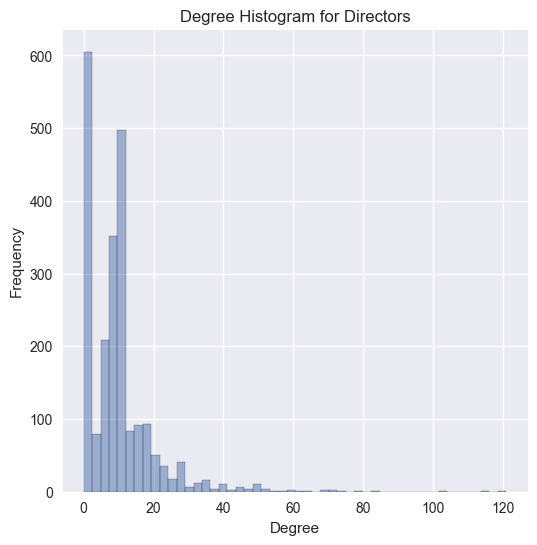

In [157]:
# Draw histograms for degree centrality of directors across genres
plt.figure(figsize=(6, 6))
plt.hist(degree_df_directors['Degree'], bins=50, alpha=0.5, edgecolor='black')

# Add titles and labels
plt.title('Degree Histogram for Directors')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

No handles with labels found to put in legend.


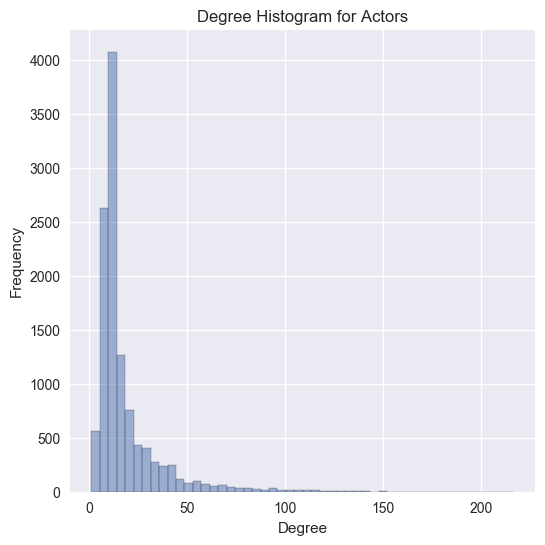

In [160]:
# Draw histograms for degree centrality of directors across genres
plt.figure(figsize=(6, 6))
plt.hist(degree_df_actors['Degree'], bins=50, alpha=0.5, edgecolor='black')

# Add titles and labels
plt.title('Degree Histogram for Actors')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

No handles with labels found to put in legend.


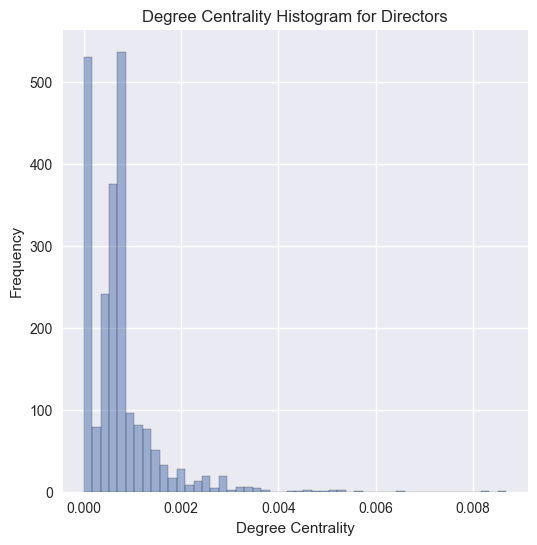

In [89]:
# Draw histograms for degree centrality of directors across genres
plt.figure(figsize=(6, 6))
plt.hist(all_directors_df['degree_centrality'], bins=50, alpha=0.5, edgecolor='black')

# Add titles and labels
plt.title('Degree Centrality Histogram for Directors')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

No handles with labels found to put in legend.


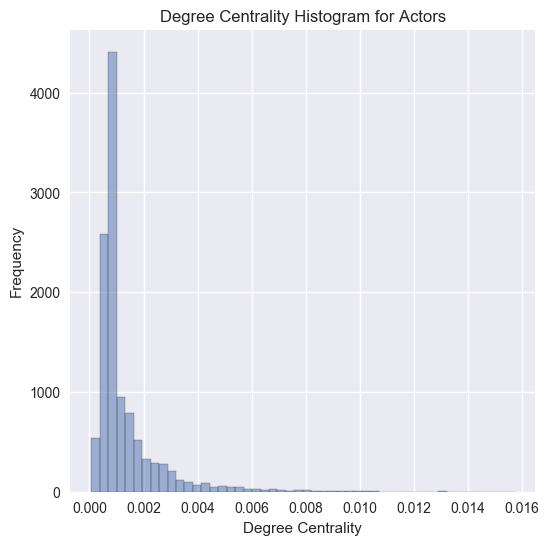

In [90]:
# Draw histograms for degree centrality of directors across genres
plt.figure(figsize=(6, 6))
plt.hist(all_actors_df['degree_centrality'], bins=50, alpha=0.5, edgecolor='black')

# Add titles and labels
plt.title('Degree Centrality Histogram for Actors')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

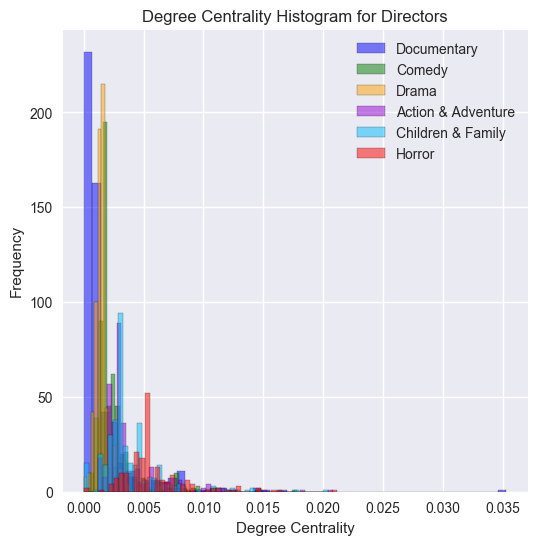

In [85]:
# Draw histograms for degree centrality of directors across genres
plt.figure(figsize=(6, 6))
plt.hist(docu_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Documentary', color='blue', edgecolor='black')
plt.hist(comedy_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Comedy', color='green', edgecolor='black')
plt.hist(drama_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Drama', color='orange', edgecolor='black')
plt.hist(action_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Action & Adventure', color='darkviolet', edgecolor='black')
plt.hist(children_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Children & Family', color='deepskyblue', edgecolor='black')
plt.hist(horror_directors_df['degree_centrality'], bins=50, alpha=0.5, label='Horror', color='red', edgecolor='black')
# Add titles and labels
plt.title('Degree Centrality Histogram for Directors')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

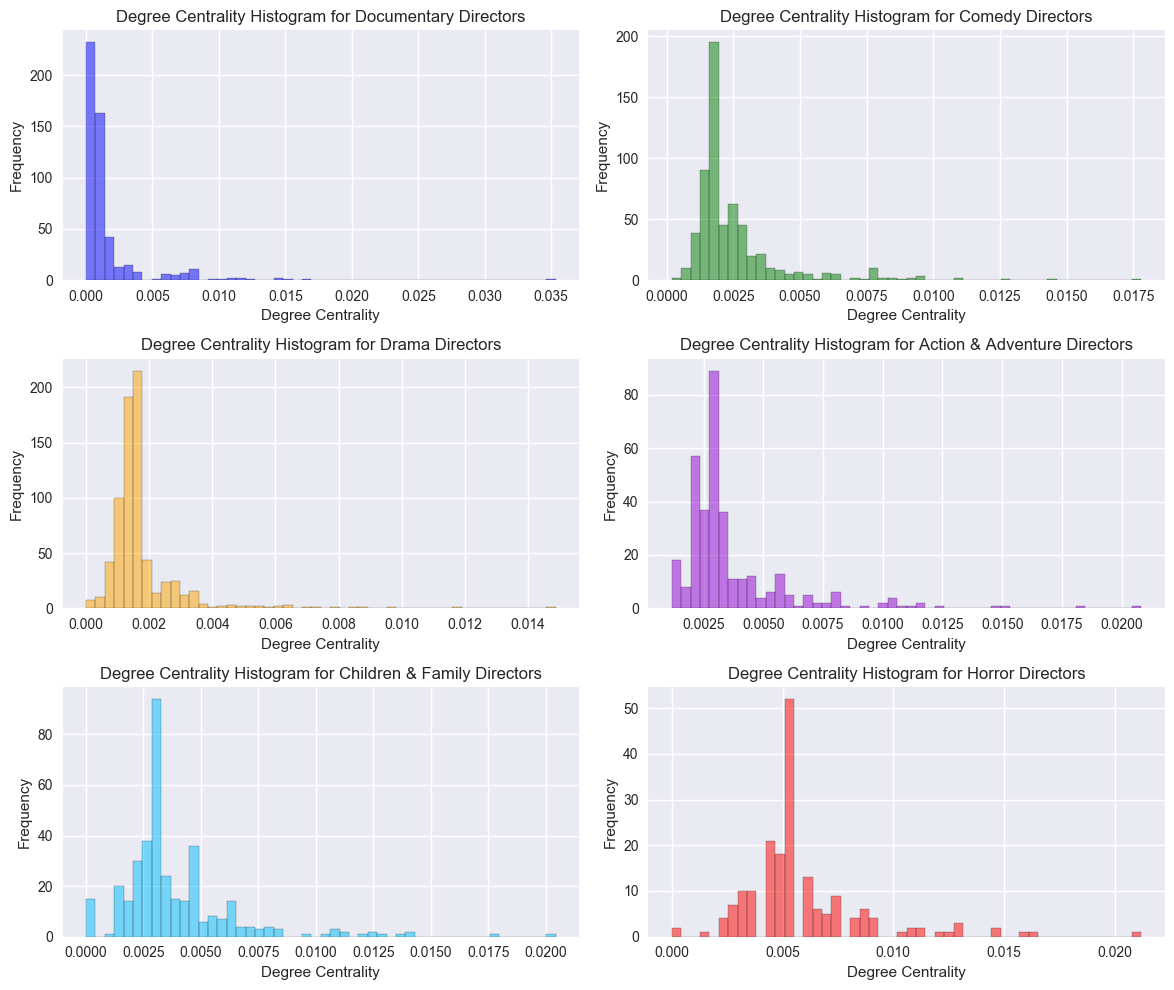

In [179]:
import matplotlib.pyplot as plt

def plot_degree_centrality_histograms_subplot(docu_directors_df, comedy_directors_df, drama_directors_df, action_directors_df, children_directors_df, horror_directors_df):
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    dfs = [docu_directors_df, comedy_directors_df, drama_directors_df, action_directors_df, children_directors_df, horror_directors_df]
    labels = ['Documentary', 'Comedy', 'Drama', 'Action & Adventure', 'Children & Family', 'Horror']
    colors = ['blue', 'green', 'orange', 'darkviolet', 'deepskyblue', 'red']
    
    for i, df in enumerate(dfs):
        ax = axs[i//2, i%2]
        ax.hist(df['degree_centrality'], bins=50, alpha=0.5, label=labels[i], color=colors[i], edgecolor='black')
        ax.set_title(f'Degree Centrality Histogram for {labels[i]} Directors')
        ax.set_xlabel('Degree Centrality')
        ax.set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Example usage
plot_degree_centrality_histograms_subplot(docu_directors_df, comedy_directors_df, drama_directors_df, action_directors_df, children_directors_df, horror_directors_df)


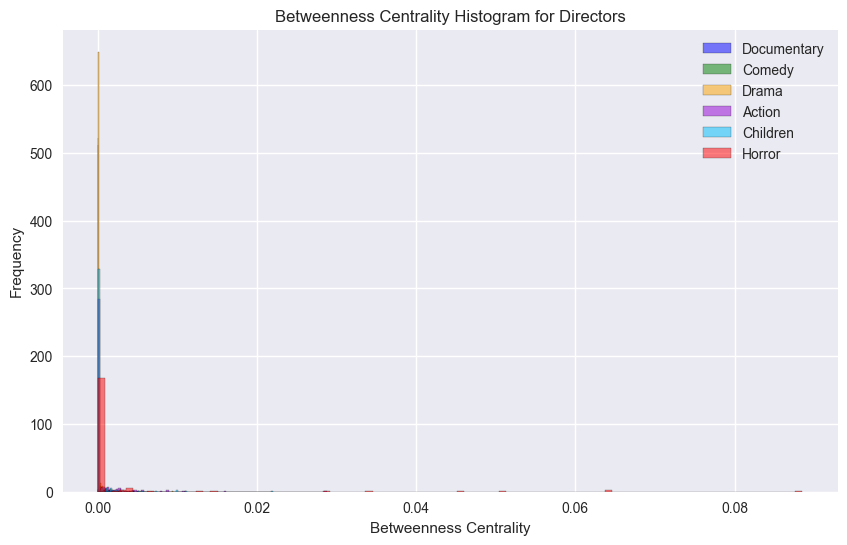

In [82]:
# Draw histograms for degree centrality of docu_directors_df and comedy_directors_df
plt.figure(figsize=(10, 6))
plt.hist(docu_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Documentary', color='blue', edgecolor='black')
plt.hist(comedy_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Comedy', color='green', edgecolor='black')
plt.hist(drama_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Drama', color='orange', edgecolor='black')
plt.hist(action_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Action ', color='darkviolet', edgecolor='black')
plt.hist(children_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Children', color='deepskyblue', edgecolor='black')
plt.hist(horror_directors_df['betweenness_centrality'], bins=100, alpha=0.5, label='Horror', color='red', edgecolor='black')
# Add titles and labels
plt.title('Betweenness Centrality Histogram for Directors')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

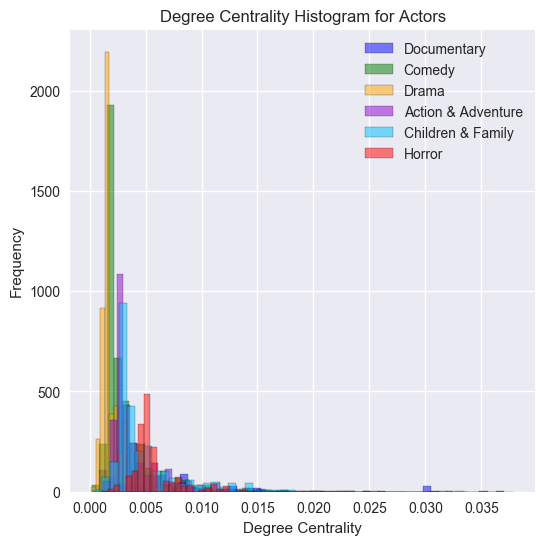

In [91]:
# Draw histograms for degree centrality of actors across genres
plt.figure(figsize=(6, 6))
plt.hist(docu_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Documentary', color='blue', edgecolor='black')
plt.hist(comedy_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Comedy', color='green', edgecolor='black')
plt.hist(drama_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Drama', color='orange', edgecolor='black')
plt.hist(action_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Action & Adventure', color='darkviolet', edgecolor='black')
plt.hist(children_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Children & Family', color='deepskyblue', edgecolor='black')
plt.hist(horror_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Horror', color='red', edgecolor='black')
# Add titles and labels
plt.title('Degree Centrality Histogram for Actors')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

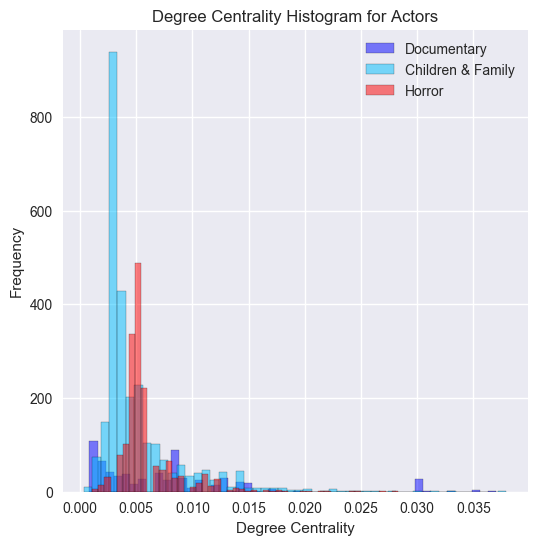

In [97]:
# Draw histograms for degree centrality of actors across genres
plt.figure(figsize=(6, 6))
plt.hist(docu_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Documentary', color='blue', edgecolor='black')
plt.hist(children_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Children & Family', color='deepskyblue', edgecolor='black')
plt.hist(horror_actors_df['degree_centrality'], bins=50, alpha=0.5, label='Horror', color='red', edgecolor='black')
# Add titles and labels
plt.title('Degree Centrality Histogram for Actors')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

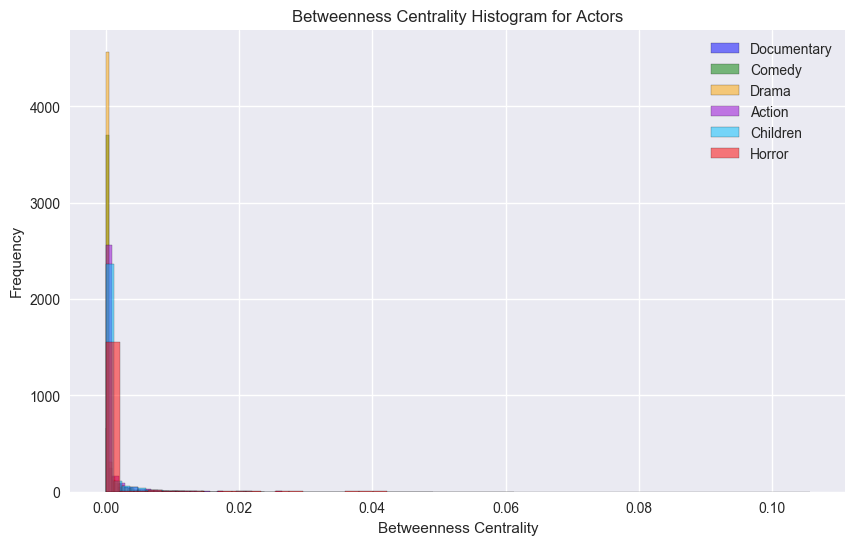

In [96]:
# Draw histograms for betweenness centrality of actors across genres
plt.figure(figsize=(10, 6))
plt.hist(docu_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Documentary', color='blue', edgecolor='black')
plt.hist(comedy_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Comedy', color='green', edgecolor='black')
plt.hist(drama_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Drama', color='orange', edgecolor='black')
plt.hist(action_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Action', color='darkviolet', edgecolor='black')
plt.hist(children_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Children', color='deepskyblue', edgecolor='black')
plt.hist(horror_actors_df['betweenness_centrality'], bins=50, alpha=0.5, label='Horror', color='red', edgecolor='black')
# Add titles and labels
plt.title('Betweenness Centrality Histogram for Actors')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

In [121]:
import numpy as np

def find_max_centrality(df):
    max_degree_centrality = np.max(df['degree_centrality'])
    max_degree_centrality_node = df.loc[df['degree_centrality'] == max_degree_centrality].index.values[0].split('_')[0]
    
    max_betweenness_centrality = np.max(df['betweenness_centrality'])
    max_betweenness_centrality_node = df.loc[df['betweenness_centrality'] == max_betweenness_centrality].index.values[0].split('_')[0]
    
    return max_degree_centrality, max_degree_centrality_node, max_betweenness_centrality, max_betweenness_centrality_node



In [123]:
centrality_director_df = filter_directors(centrality_df)
centrality_actor_df = filter_actors(centrality_df)

In [124]:
max_degree_centrality_all, max_degree_centrality_node_all, max_betweenness_centrality_all, max_betweenness_centrality_node_all = find_max_centrality(centrality_director_df)
max_degree_centrality_docu, max_degree_centrality_node_docu, max_betweenness_centrality_docu, max_betweenness_centrality_node_docu = find_max_centrality(docu_directors_df)
max_degree_centrality_comedy, max_degree_centrality_node_comedy, max_betweenness_centrality_comedy, max_betweenness_centrality_node_comedy = find_max_centrality(comedy_directors_df)
max_degree_centrality_drama, max_degree_centrality_node_drama, max_betweenness_centrality_drama, max_betweenness_centrality_node_drama = find_max_centrality(drama_directors_df)
max_degree_centrality_action, max_degree_centrality_node_action, max_betweenness_centrality_action, max_betweenness_centrality_node_action = find_max_centrality(action_directors_df)
max_degree_centrality_children, max_degree_centrality_node_children, max_betweenness_centrality_children, max_betweenness_centrality_node_children = find_max_centrality(children_directors_df)
max_degree_centrality_horror, max_degree_centrality_node_horror, max_betweenness_centrality_horror, max_betweenness_centrality_node_horror = find_max_centrality(horror_directors_df)

# Create a DataFrame
max_centrality_data = {
    'Genre': ['All', 'Documentary', 'Comedy', 'Drama', 'Action', 'Children', 'Horror'],
    'Max_Degree_Centrality': [max_degree_centrality_all, max_degree_centrality_docu, max_degree_centrality_comedy, 
                               max_degree_centrality_drama, max_degree_centrality_action, max_degree_centrality_children,
                               max_degree_centrality_horror],
    'Max_Degree_Centrality_Node': [max_degree_centrality_node_all, max_degree_centrality_node_docu, max_degree_centrality_node_comedy, 
                                    max_degree_centrality_node_drama, max_degree_centrality_node_action, max_degree_centrality_node_children,
                                    max_degree_centrality_node_horror],
    'Max_Betweenness_Centrality': [max_betweenness_centrality_all, max_betweenness_centrality_docu, 
                                    max_betweenness_centrality_comedy, max_betweenness_centrality_drama, 
                                    max_betweenness_centrality_action, max_betweenness_centrality_children,
                                    max_betweenness_centrality_horror],
    'Max_Betweenness_Centrality_Node': [max_betweenness_centrality_node_all, max_betweenness_centrality_node_docu, 
                                         max_betweenness_centrality_node_comedy, max_betweenness_centrality_node_drama, 
                                         max_betweenness_centrality_node_action, max_betweenness_centrality_node_children,
                                         max_betweenness_centrality_node_horror]
}

max_centrality_df = pd.DataFrame(max_centrality_data)

max_centrality_df


Genre  Max_Degree_Centrality Max_Degree_Centrality_Node  \
0          All               0.008686            Martin Scorsese   
1  Documentary               0.035324               Peter Spirer   
2       Comedy               0.017798                Steve Brill   
3        Drama               0.014873            Martin Scorsese   
4       Action               0.020827           Don Michael Paul   
5     Children               0.020428           Robert Rodriguez   
6       Horror               0.021207              Scott Stewart   

   Max_Betweenness_Centrality Max_Betweenness_Centrality_Node  
0                    0.004078                Steven Spielberg  
1                    0.003687                    Peter Spirer  
2                    0.006846                Robert Rodriguez  
3                    0.011067                Steven Spielberg  
4                    0.028744                Don Michael Paul  
5                    0.021960                Robert Rodriguez  
6                    0.088515                   Scott Stewart

In [126]:
# Call the function for each DataFrame
max_degree_centrality_all_actor, max_degree_centrality_node_all_actor, max_betweenness_centrality_all_actor, max_betweenness_centrality_node_all_actor = find_max_centrality(centrality_actor_df)
max_degree_centrality_docu_actor, max_degree_centrality_node_docu_actor, max_betweenness_centrality_docu_actor, max_betweenness_centrality_node_docu_actor = find_max_centrality(docu_actors_df)
max_degree_centrality_comedy_actor, max_degree_centrality_node_comedy_actor, max_betweenness_centrality_comedy_actor, max_betweenness_centrality_node_comedy_actor = find_max_centrality(comedy_actors_df)
max_degree_centrality_drama_actor, max_degree_centrality_node_drama_actor, max_betweenness_centrality_drama_actor, max_betweenness_centrality_node_drama_actor = find_max_centrality(drama_actors_df)
max_degree_centrality_action_actor, max_degree_centrality_node_action_actor, max_betweenness_centrality_action_actor, max_betweenness_centrality_node_action_actor = find_max_centrality(action_actors_df)
max_degree_centrality_children_actor, max_degree_centrality_node_children_actor, max_betweenness_centrality_children_actor, max_betweenness_centrality_node_children_actor = find_max_centrality(children_actors_df)
max_degree_centrality_horror_actor, max_degree_centrality_node_horror_actor, max_betweenness_centrality_horror_actor, max_betweenness_centrality_node_horror_actor = find_max_centrality(horror_actors_df)

# Create a DataFrame
max_centrality_data_actor = {
    'Genre': ['All', 'Documentary', 'Comedy', 'Drama', 'Action', 'Children', 'Horror'],
    'Max_Degree_Centrality': [max_degree_centrality_all_actor, max_degree_centrality_docu_actor, max_degree_centrality_comedy_actor, 
                               max_degree_centrality_drama_actor, max_degree_centrality_action_actor, max_degree_centrality_children_actor,
                               max_degree_centrality_horror_actor],
    'Max_Degree_Centrality_Node': [max_degree_centrality_node_all_actor, max_degree_centrality_node_docu_actor, max_degree_centrality_node_comedy_actor, 
                                    max_degree_centrality_node_drama_actor, max_degree_centrality_node_action_actor, max_degree_centrality_node_children_actor,
                                    max_degree_centrality_node_horror_actor],
    'Max_Betweenness_Centrality': [max_betweenness_centrality_all_actor, max_betweenness_centrality_docu_actor, 
                                    max_betweenness_centrality_comedy_actor, max_betweenness_centrality_drama_actor, 
                                    max_betweenness_centrality_action_actor, max_betweenness_centrality_children_actor,
                                    max_betweenness_centrality_horror_actor],
    'Max_Betweenness_Centrality_Node': [max_betweenness_centrality_node_all_actor, max_betweenness_centrality_node_docu_actor, 
                                         max_betweenness_centrality_node_comedy_actor, max_betweenness_centrality_node_drama_actor, 
                                         max_betweenness_centrality_node_action_actor, max_betweenness_centrality_node_children_actor,
                                         max_betweenness_centrality_node_horror_actor]
}

max_centrality_df_actor = pd.DataFrame(max_centrality_data_actor)

max_centrality_df_actor


Genre  Max_Degree_Centrality Max_Degree_Centrality_Node  \
0          All               0.015720               James Franco   
1  Documentary               0.037006                      Ice-T   
2       Comedy               0.033835               Adam Sandler   
3        Drama               0.020150               James Franco   
4       Action               0.031974               Willem Dafoe   
5     Children               0.037938            Fred Tatasciore   
6       Horror               0.028276              Michael Gross   

   Max_Betweenness_Centrality Max_Betweenness_Centrality_Node  
0                    0.015536               Samuel L. Jackson  
1                    0.004342                          Common  
2                    0.023943                   Molly Shannon  
3                    0.023708                    James Franco  
4                    0.049105               Samuel L. Jackson  
5                    0.061219                     Tara Strong  
6                    0.105663                      Ali Larter

## Transitivity and Clustering coefficient

In [146]:
list_graphs = [full_graph, drama_graph, docu_graph, comedy_graph, horror_graph, children_graph, action_graph]
graph_names = ['full_graph', 'drama_graph', 'docu_graph', 'comedy_graph', 'horror_graph', 'children_graph', 'action_graph']

# Compute the transitivity and clustering coefficient for each graph
transitivity_values = [nx.transitivity(graph) for graph in list_graphs]
clustering_coefs = [nx.average_clustering(graph) for graph in list_graphs]

# Create a DataFrame to store the transitivity values and clustering coefficients
data = {
    'transitivity': transitivity_values,
    'clustering coefficient': clustering_coefs
}

transitivity_df = pd.DataFrame(data, index=graph_names)
transitivity_df

NameError: name 'drama_graph' is not defined

In [149]:
# Function to calculate graph properties
def calculate_graph_properties(G):
    properties = {}
    properties['no_of_nodes'] = G.number_of_nodes()
    properties['no_of_edges'] = G.number_of_edges()
    properties['transitivity'] = nx.transitivity(G)
    properties['average_clustering'] = nx.average_clustering(G)
    properties['edge_density'] = nx.density(G)
    properties['average_degree'] = np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)
    return properties

In [150]:
# List of graphs and their names
list_graphs = [full_graph, drama_graph, docu_graph, comedy_graph, horror_graph, children_graph, action_graph]
graph_names = ['full_graph', 'drama_graph', 'docu_graph', 'comedy_graph', 'horror_graph', 'children_graph', 'action_graph']

# Initialize an empty DataFrame to store the properties
properties_df = pd.DataFrame(columns=[
    'no_of_nodes', 'no_of_edges', 'transitivity', 'average_clustering', 'edge_density',
    'average_degree'
])

# Calculate properties for each graph and store in the DataFrame
for graph, name in zip(list_graphs, graph_names):
    print(name)
    properties = calculate_graph_properties(graph)
    properties_df.loc[name] = properties

full_graph
drama_graph
docu_graph
comedy_graph
horror_graph
children_graph
action_graph


In [151]:
properties_df

no_of_nodes no_of_edges  transitivity  average_clustering  \
full_graph           13932      116403      0.362595            0.786975   
drama_graph           6254       43588      0.512153            0.874630   
docu_graph            1190        3405      0.937605            0.529365   
comedy_graph          5114       43139      0.479526            0.854887   
horror_graph          1840       10154      0.818650            0.947619   
children_graph        3085       23281      0.670626            0.889592   
action_graph          3410       24879      0.585789            0.883981   

                edge_density  average_degree  
full_graph          0.001199       16.710164  
drama_graph         0.002229       13.939239  
docu_graph          0.004813        5.722689  
comedy_graph        0.003300       16.870943  
horror_graph        0.006002       11.036957  
children_graph      0.004894       15.093031  
action_graph        0.004280       14.591789

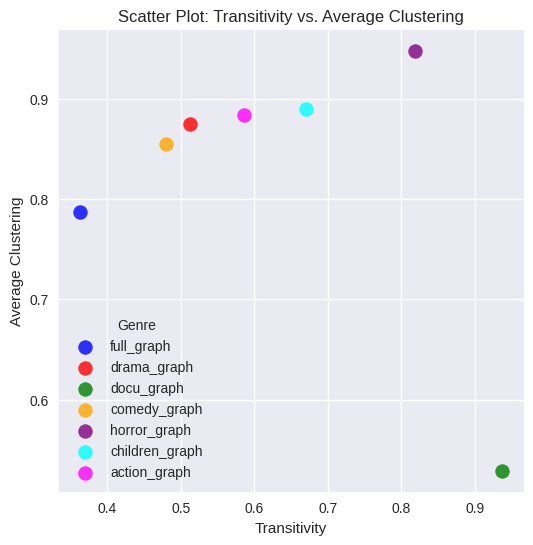

In [ ]:
# Assign colors to each genre
colors = {
    'full_graph': 'blue',
    'drama_graph': 'red',
    'docu_graph': 'green',
    'comedy_graph': 'orange',
    'horror_graph': 'purple',
    'children_graph': 'cyan',
    'action_graph': 'magenta'
}

# Create scatter plot
plt.figure(figsize=(6, 6))
for genre, color in colors.items():
    plt.scatter(properties_df.loc[genre, 'transitivity'], properties_df.loc[genre, 'average_clustering'],
                color=color, label=genre, s=100, alpha=.8)

# Customize plot
plt.xlabel('Transitivity')
plt.ylabel('Average Clustering')
plt.title('Scatter Plot: Transitivity vs. Average Clustering')
plt.gca().spines[['top', 'right']].set_visible(False)

# Add legend
plt.legend(title='Genre')
plt.show()

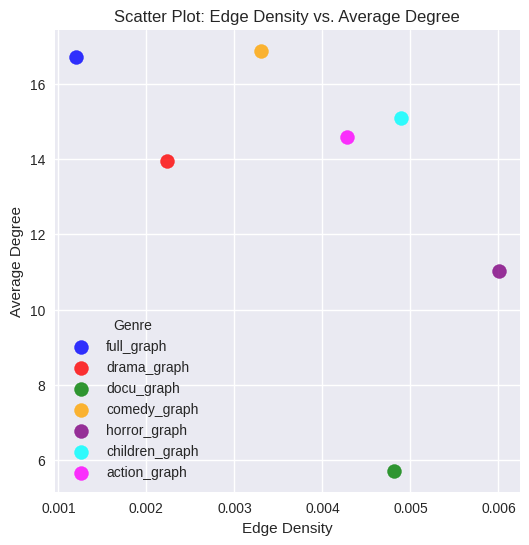

In [ ]:
# Assign colors to each genre
colors = {
    'full_graph': 'blue',
    'drama_graph': 'red',
    'docu_graph': 'green',
    'comedy_graph': 'orange',
    'horror_graph': 'purple',
    'children_graph': 'cyan',
    'action_graph': 'magenta'
}

# Create scatter plot
plt.figure(figsize=(6, 6))
for genre, color in colors.items():
    plt.scatter(properties_df.loc[genre, 'edge_density'], properties_df.loc[genre, 'average_degree'],
                color=color, label=genre, s=100, alpha=.8)

# Customize plot
plt.xlabel('Edge Density')
plt.ylabel('Average Degree')
plt.title('Scatter Plot: Edge Density vs. Average Degree')
plt.gca().spines[['top', 'right']].set_visible(False)

# Add legend
plt.legend(title='Genre')
plt.show()

In [144]:
properties_df

NameError: name 'properties_df' is not defined

## Community detection

Initialize a graph where nodes represent movies, and an edge exists between two movies if they share the same cast member or director.

In [ ]:
import networkx as nx
import time

# Assuming `df` is your DataFrame and `G` is your initial graph

# Initialize the original graph
G = nx.Graph(label="MOVIE")

start_time = time.time()
for i, row in df.iterrows():
    if i % 1000 == 0:
        print(f" iter {i} -- {time.time() - start_time} seconds --")

    G.add_node(row['title'], key=row['show_id'], label="MOVIE", mtype=row['type'], rating=row['rating'])

    for element in row['actors']:
        G.add_node(element, label="ACTOR")
        G.add_edge(row['title'], element, label="ACTED_IN", weight=1)

    for element in row['directors']:
        G.add_node(element, label="DIRECTOR")
        G.add_edge(row['title'], element, label="DIRECTED_BY", weight=5)

print(f" finish -- {time.time() - start_time} seconds --")

 iter 0 -- 0.040749311447143555 seconds --
 iter 1000 -- 0.2659878730773926 seconds --
 iter 2000 -- 0.5324454307556152 seconds --
 iter 4000 -- 1.0130524635314941 seconds --
 iter 6000 -- 1.4416487216949463 seconds --
 iter 7000 -- 1.6518714427947998 seconds --
 finish -- 2.081418037414551 seconds --


NameError: name 'edge_labels' is not defined

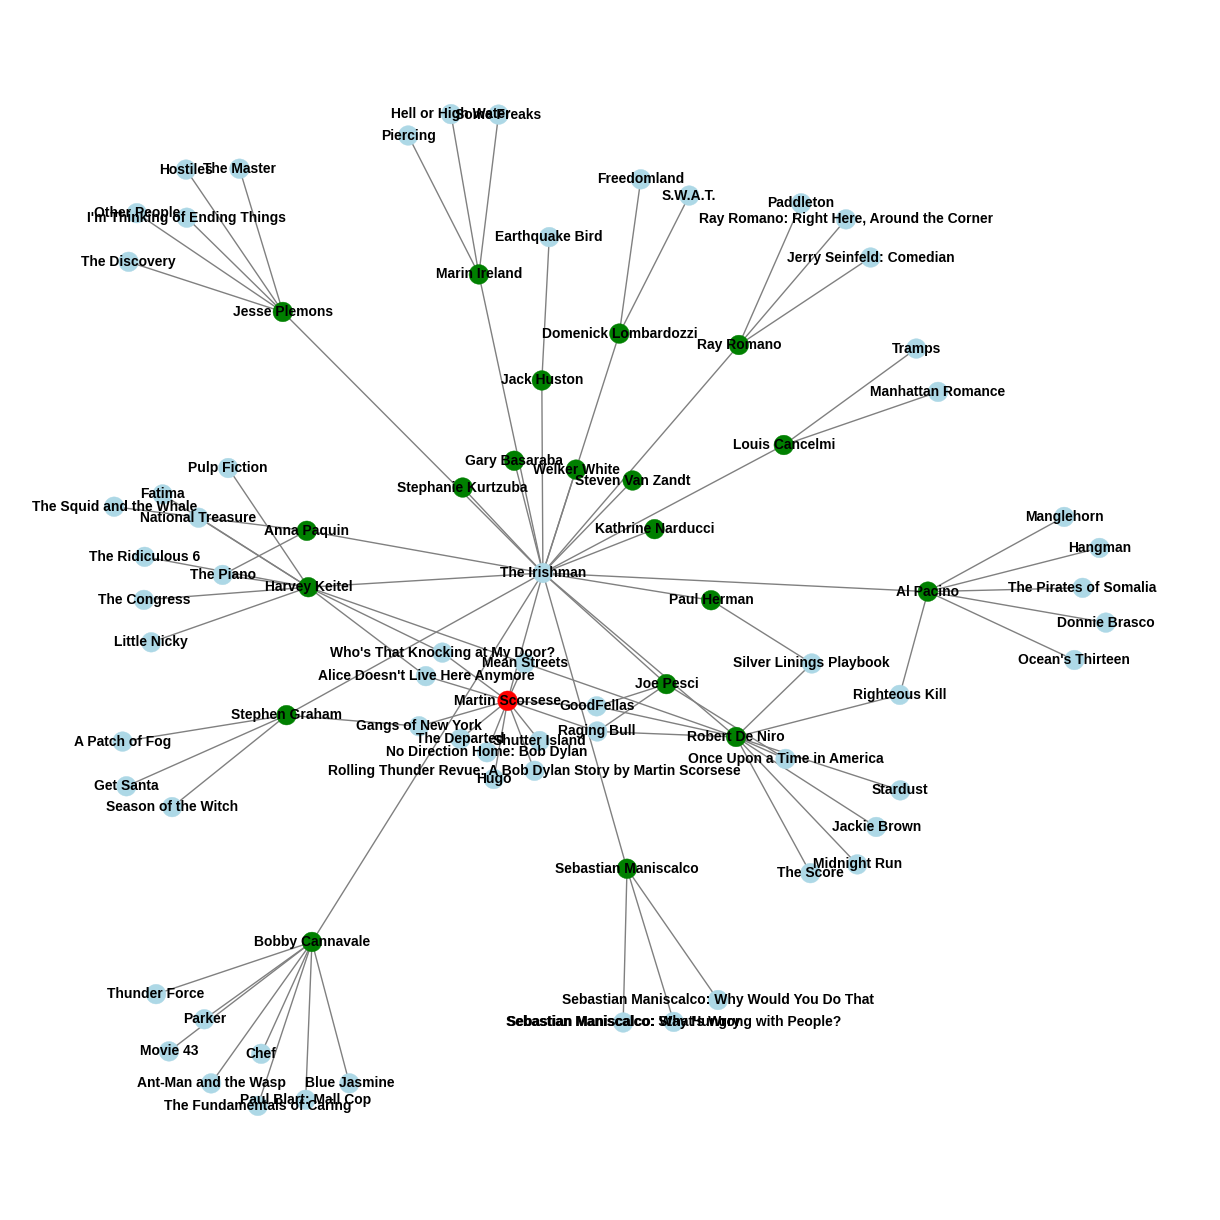

In [ ]:
def draw_movie_subgraph(graph, movie_name):
    # Check if the movie exists in the graph
    if movie_name not in graph:
        print(f"Movie '{movie_name}' not found in the graph.")
        return

    # Get the neighbors of the movie (directors and actors)
    neighbors = list(graph.neighbors(movie_name))

    # Initialize a set for nodes to include in the subgraph
    subgraph_nodes = set(neighbors)
    subgraph_nodes.add(movie_name)

    # Add other movies that share the same directors and actors
    for neighbor in neighbors:
        for n in graph.neighbors(neighbor):
            if n != movie_name:  # Exclude the original movie itself
                subgraph_nodes.add(n)

    # Create the subgraph
    subgraph = graph.subgraph(subgraph_nodes)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # You can change the layout as needed
    plt.figure(figsize=(12, 12))

    # Set colors based on node type
    node_colors = []
    for node in subgraph:
        if graph.nodes[node]['label'] == 'MOVIE':
            node_colors.append('lightblue')
        elif graph.nodes[node]['label'] == 'ACTOR':
            node_colors.append('green')
        elif graph.nodes[node]['label'] == 'DIRECTOR':
            node_colors.append('red')

    nx.draw(subgraph, pos, with_labels=True, node_size=200, node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')

    # Draw edge labels if needed
    nx.draw_networkx_edge_labels(subgraph, pos)

    plt.title(f"Subgraph for Movie: {movie_name}")
    plt.show()

# Example usage:
movie_name = 'The Irishman'  # Replace with the name of the movie you want to visualize
draw_movie_subgraph(G, movie_name)


In [ ]:
# Create the new graph based on common actors or directors
def create_new_graph_with_common_elements(G):
    G_new = nx.Graph(label="MOVIE")

    # Add movie nodes to the new graph
    for node, data in G.nodes(data=True):
        if data['label'] == "MOVIE":
            G_new.add_node(node, **data)

    start_time = time.time()
    count = 0

    # Add edges between movies that share common actors or directors
    for node1, data1 in G.nodes(data=True):
        if data1['label'] == "MOVIE":
            neighbors1 = set(G.neighbors(node1))
            for node2, data2 in G.nodes(data=True):
                if node2 != node1 and data2['label'] == "MOVIE":
                    neighbors2 = set(G.neighbors(node2))
                    common_neighbors = neighbors1 & neighbors2
                    if common_neighbors:
                        G_new.add_edge(node1, node2, weight=len(common_neighbors))

            count += 1
            if count % 1000 == 0:
                print(f" iter {count} -- {time.time() - start_time} seconds --")

    print(f"New graph creation finished -- {time.time() - start_time} seconds --")
    return G_new

In [ ]:
G_new = create_new_graph_with_common_elements(G)

 iter 1000 -- 17.578259468078613 seconds --
 iter 2000 -- 36.87779116630554 seconds --
 iter 3000 -- 54.10839104652405 seconds --
 iter 4000 -- 71.80681276321411 seconds --
 iter 5000 -- 89.05597138404846 seconds --
 iter 6000 -- 106.51584029197693 seconds --
New graph creation finished -- 110.16115713119507 seconds --


In [ ]:
# Example usage:
print(f"Number of nodes in the new graph: {G_new.number_of_nodes()}")
print(f"Number of edges in the new graph: {G_new.number_of_edges()}")

Number of nodes in the new graph: 6168
Number of edges in the new graph: 54512


In [ ]:
def draw_movie_subgraph_direct_neighbors(graph, movie_name):
    # Check if the movie exists in the graph
    if movie_name not in graph:
        print(f"Movie '{movie_name}' not found in the graph.")
        return

    # Get the neighbors of the movie (directors and actors)
    neighbors = list(graph.neighbors(movie_name))

    # Initialize a set for nodes to include in the subgraph
    subgraph_nodes = set(neighbors)
    subgraph_nodes.add(movie_name)

    # Create the subgraph with only the movie and its direct neighbors
    subgraph = graph.subgraph(subgraph_nodes)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # You can change the layout as needed
    plt.figure(figsize=(12, 12))

    # Set colors based on node type
    node_colors = []
    for node in subgraph:
        if graph.nodes[node]['label'] == 'MOVIE':
            node_colors.append('lightblue')


    nx.draw(subgraph, pos, with_labels=True, node_size=200, node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')

    # Draw edge labels if needed
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

    plt.title(f"Subgraph for Movie: {movie_name}")
    plt.show()


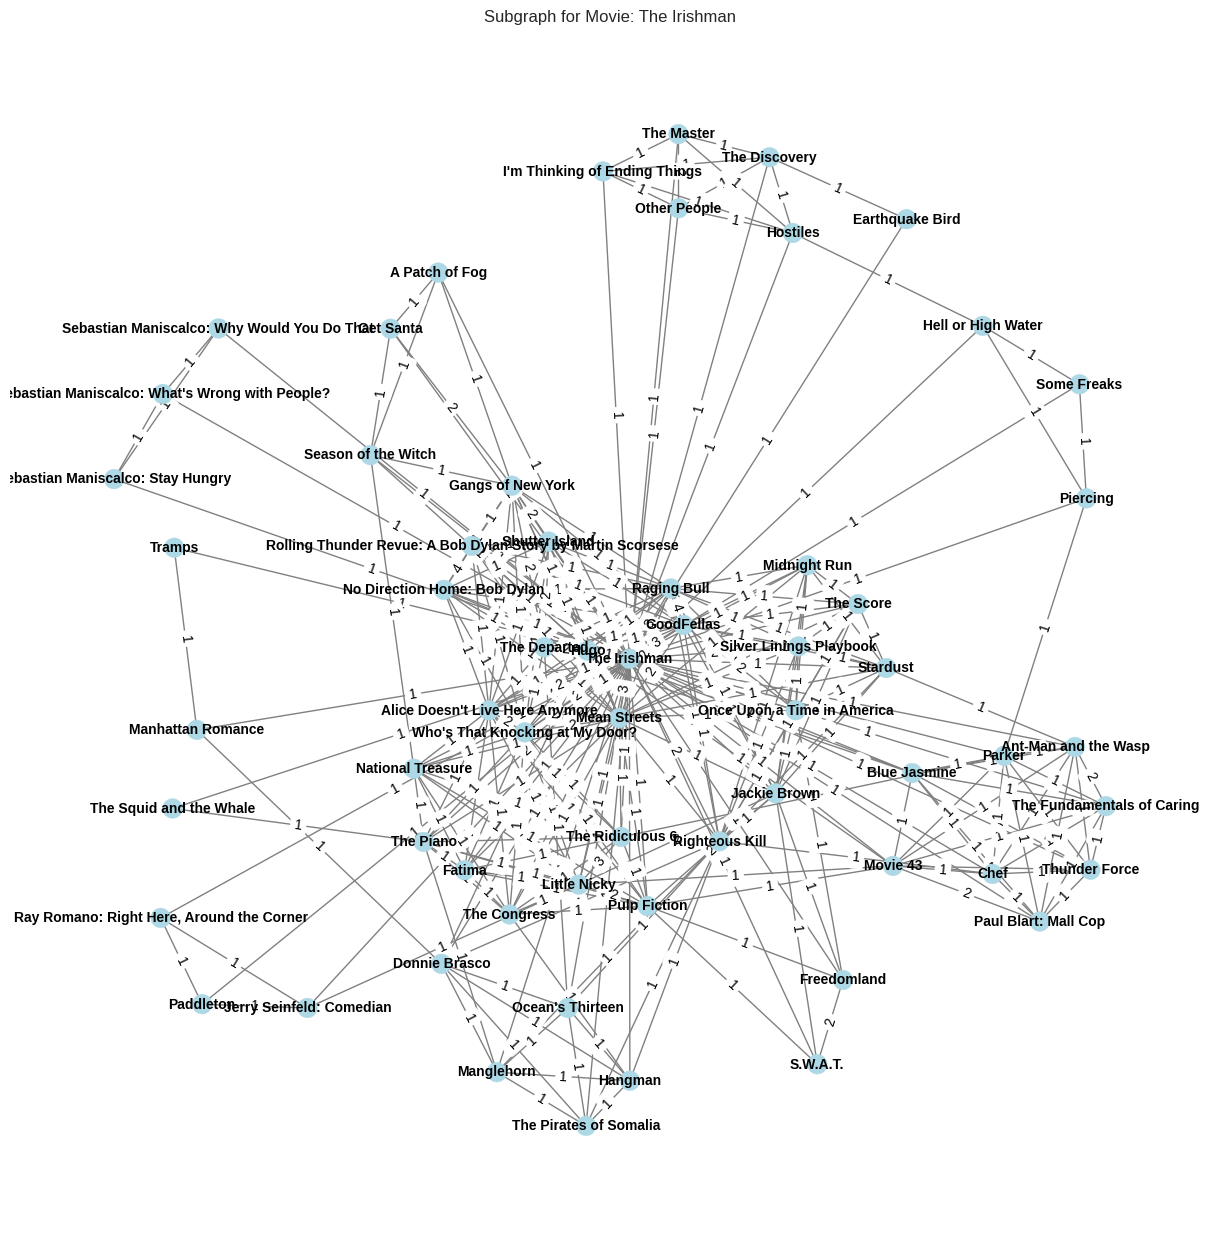

In [ ]:
# Draw subgraph for a specific movie
movie_name = 'The Irishman'  # Replace with the name of the movie you want to visualize
draw_movie_subgraph_direct_neighbors(G_new, movie_name)

In [ ]:
## utils function

def clustering_func(graph_netx, algo, resolution=1):
  graph = ig.Graph.from_networkx(graph_netx)

  if algo == "multilevel":
    cl = graph.community_multilevel(resolution=resolution)
  elif algo == "leiden_mod":
    cl = graph.community_leiden(objective_function="modularity",resolution=resolution)
  elif algo == "leiden_cpm":
    cl = graph.community_leiden(objective_function="CPM", resolution=resolution)
  elif algo == "infomap":
    cl = graph.community_infomap(trials=20)

  membership = cl.membership
  np_membership = np.array(membership)

  # Get a tuple of unique clusters & their frequency in numpy array
  uniqueClusters, occurCount = np.unique(np_membership, return_counts=True)
  print('In the network there are ', len(uniqueClusters), ' clusters.')

  # Zip both the arrays
  #listOfUniqueClusters = zip(uniqueClusters, occurCount)
  # print('Unique Clusters along with occurrence Count')
  # Iterate over the zip object
  #for elem in listOfUniqueClusters:
  #  print('Cluster No: ', elem[0] , ' Contains : ' , elem[1], ' nodes')

  modularity = graph.modularity(membership)
  print("The modularity for the",algo, "algorithm is {}".format(format(modularity, '.2f')))

  # Summary
  summary = [len(uniqueClusters), modularity]

  return cl, summary

def cluster_plot(graph_netx, cluster, algo, size, filename, show_labels=False):

  """
  Kamada-Kawai layout: 'kk'
  Fruchterman-Reingold layout: 'fr'
  DRL layout: 'drl'
  """
  graph = ig.Graph.from_networkx(graph_netx)
  # Calculate betweenness
  betweenness = graph.betweenness(weights=None)

  # Define style from network plotting
  visual_style = {}
  visual_style["mark_groups"] = True
  visual_style["vertex_size"] = [7 + v * 0.0001 for v in betweenness]
  visual_style["edge_width"] = 1
  visual_style["layout"] = algo
  visual_style["bbox"] = (size,size)
  visual_style["margin"] = 20

  if show_labels == True:
    visual_style["vertex_label"] = graph.vs["label"]
    visual_style["vertex_label_size"]=8
  else:
    visual_style["vertex_label"] = None

  # Save Graph
  out = ig.plot(cluster, **visual_style)
  out.save(filename)

  # Read and show Graph
  plt.figure(figsize=(12,12))
  img=mpimg.imread(filename)
  plt.axis('off')
  plt.imshow(img)


def create_graph_by_actor_genre(data, genre):
  data_genre = data[data['categories'].apply(lambda x: genre in x)]

  graph_actor = nx.Graph()
  for _, row in data_genre.iterrows():
    actors = row['actors']
    for actor in actors:
      graph_actor.add_node(actor)

    # Add edges between actors in the same project
    for i in range(len(actors)):
      for j in range(i + 1, len(actors)):
        graph_actor.add_edge(actors[i], actors[j])

  return graph_actor



def create_sub_graph(graph, node_threshold):
   # Get nodes with more than 5 connections
  selected_nodes = [node for node, degree in graph.degree() if degree >= node_threshold]

    # Create a subgraph containing selected nodes and their neighbors
  subgraph = graph.subgraph(selected_nodes).copy()
  return subgraph




def create_feature_table_for_actor(data, genre):
  data_genre = data[data['categories'].apply(lambda x: genre in x)]

  data_genre_unlist = data_genre.explode('actors').reset_index(drop=True)

  data_genre_unlist['duration'] = data_genre_unlist.duration.str.replace(' min', '').astype(float)

  data_genre_group = (data_genre_unlist
                       .groupby('actors')
                       .agg({'show_id':'nunique', 'director':'nunique', 'rating':'nunique', 'duration':'mean'})
                       .reset_index())

  data_genre_group.columns = ['actors', 'num_movie', 'num_director', 'num_rating_unique', 'avg_duration']

  return data_genre_group


def node_community(cluster_result):
  community = cluster_result.membership
  nodes = cluster_result.graph.vs['_nx_name']
  node_community_data = pd.DataFrame({'nodes':nodes,
                                        'community':community})

  return node_community_data


def graph_measure(cluster_result):
  nodes = cluster_result.graph.vs['_nx_name']
  degree = cluster_result.graph.degree()
  closeness = cluster_result.graph.closeness()
  betweenness = cluster_result.graph.betweenness()
  eigenvector = cluster_result.graph.eigenvector_centrality()
  centrality_data = pd.DataFrame({'nodes':nodes,
                                   'degree':degree,
                                   'closeness':closeness,
                                   'betweenness': betweenness,
                                   'eigenvector':eigenvector})
  return centrality_data

In [ ]:
## community detection
g_louvain_movies, g_louvain_sum_movies = clustering_func(G_new, "multilevel", resolution=0.5)
g_leiden_movies, g_leiden_sum_movies = clustering_func(G_new, "leiden_mod", resolution=0.5)
#g_infomap_movies, g_infomap_sum_movies = clustering_func(G_new, "infomap")

In the network there are  897  clusters.
The modularity for the multilevel algorithm is 0.62
In the network there are  897  clusters.
The modularity for the leiden_mod algorithm is 0.62


In [ ]:
node_community_movies = node_community(g_louvain_movies)

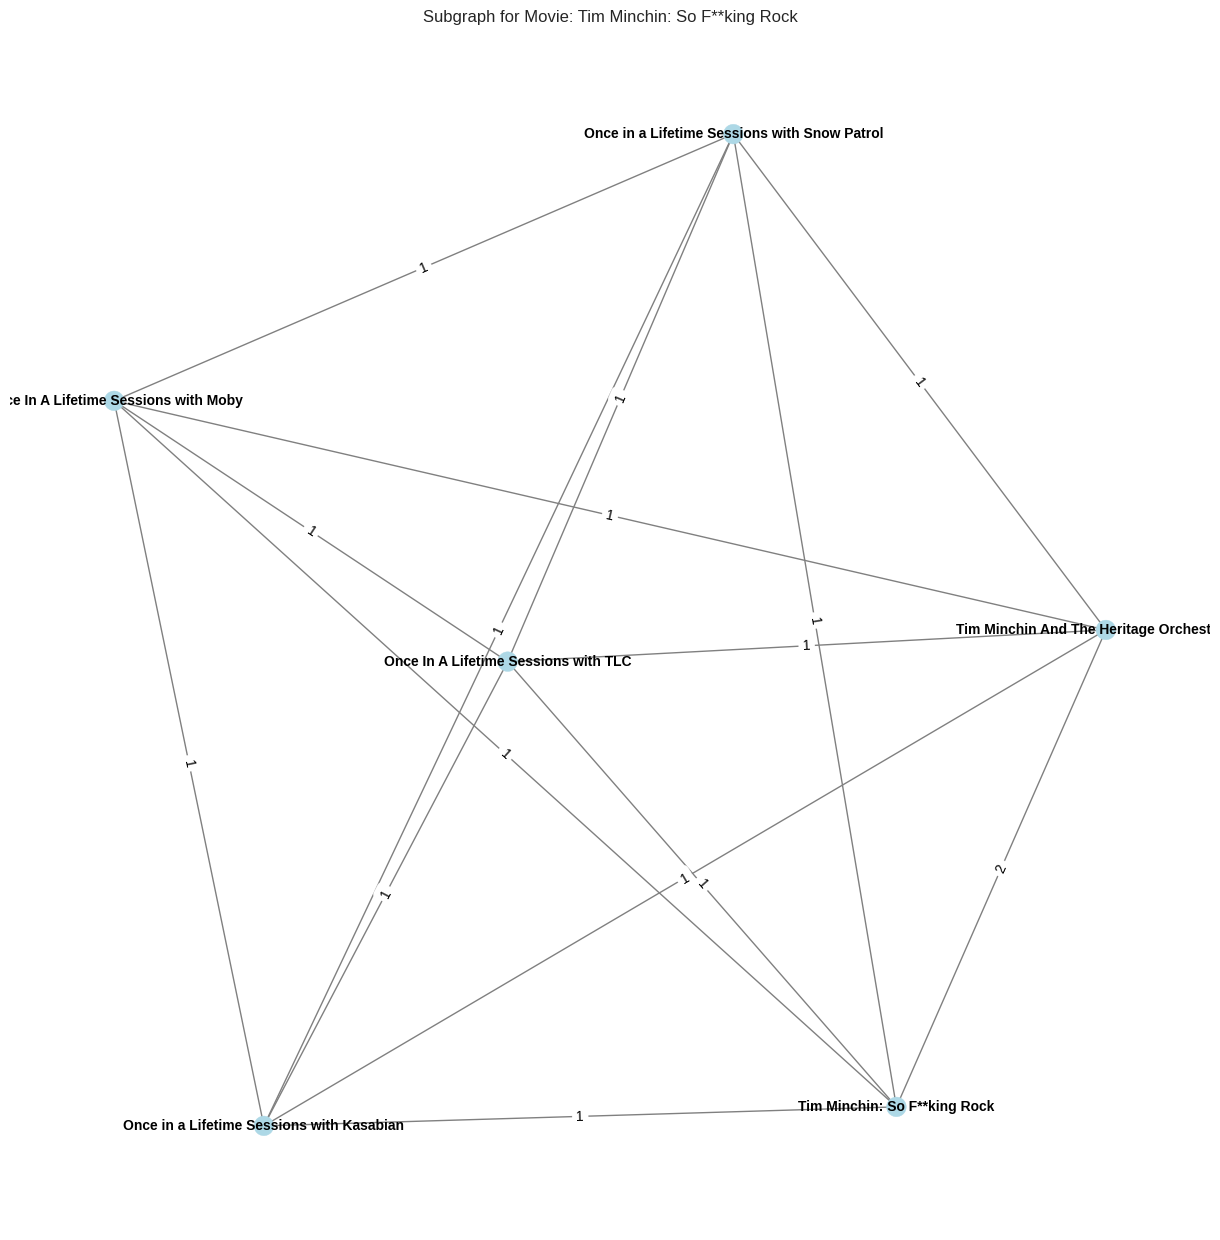

In [ ]:
# Draw subgraph for a specific movie
movie_name = 'Tim Minchin: So F**king Rock'  # Replace with the name of the movie you want to visualize
draw_movie_subgraph_direct_neighbors(G_new, movie_name)

In [ ]:
node_community_movies.groupby('community').agg('count').reset_index().sort_values('nodes', ascending=False)

community  nodes
1            1   2598
7            7    955
25          25    281
11          11    156
5            5    145
..         ...    ...
355        355      1
356        356      1
357        357      1
358        358      1
896        896      1

[897 rows x 2 columns]

In [ ]:
node_community_movies

nodes  community
0                 Dick Johnson Is Dead          0
1                            Ganglands          1
2                        Midnight Mass          1
3     My Little Pony: A New Generation          1
4                              Sankofa          2
...                                ...        ...
6163                           Zinzana         16
6164                            Zodiac          1
6165                        Zombieland          1
6166                              Zoom          1
6167                            Zubaan          7

[6168 rows x 2 columns]

In [ ]:
movie_genre = usa[['categories', 'title']].explode(['categories']).reset_index(drop=True)
movie_genre

categories                 title
0                Documentaries  Dick Johnson Is Dead
1                       Dramas               Sankofa
2           Independent Movies               Sankofa
3         International Movies               Sankofa
4                     Comedies          The Starling
...                        ...                   ...
4913                 Thrillers                Zodiac
4914                  Comedies            Zombieland
4915             Horror Movies            Zombieland
4916  Children & Family Movies                  Zoom
4917                  Comedies                  Zoom

[4918 rows x 2 columns]

In [ ]:
movie_genre[movie_genre.title.isin(node_community_movies[node_community_movies.community==7]['nodes'])].groupby('categories').agg({'title':'nunique'}).reset_index().sort_values('title', ascending=False)

categories  title
4                    Dramas     18
7      International Movies     12
6        Independent Movies      8
2                  Comedies      5
0        Action & Adventure      2
9                 Thrillers      2
1  Children & Family Movies      1
3             Documentaries      1
5             Horror Movies      1
8              LGBTQ Movies      1

In [ ]:
movie_genre[movie_genre.title.isin(node_community_movies[node_community_movies.community==1]['nodes'])].shape

(3902, 2)

In [59]:
from networkx.algorithms.link_prediction import preferential_attachment
# Calculate preferential attachment scores for each pair of director and actor
def calculate_preferential_attachment(G):
    # Extract director and actor nodes
    director_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'director']
    actor_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'actor']

    print(f"Number of directors: {len(director_nodes)}")
    print(f"Number of actors: {len(actor_nodes)}")

    # Generate all possible director-actor pairs
    pairs = [(d, a) for d in director_nodes for a in actor_nodes]
    total_pairs = len(pairs)
    print(f"Generated {total_pairs} director-actor pairs for preferential attachment calculation.")

    # Calculate preferential attachment scores
    pa_scores = []
    for idx, (u, v, p) in enumerate(preferential_attachment(G, pairs)):
        pa_scores.append((u, v, p))
        # Print progress
        if idx % (total_pairs // 100) == 0:  # Print progress every 1%
            print(f"Progress: {idx / total_pairs * 100:.2f}%")

    print("Preferential attachment scores calculated.")

    # Convert scores to a DataFrame for better visualization
    pa_df = pd.DataFrame(pa_scores, columns=['Director', 'Actor', 'Score'])
    print("Converted preferential attachment scores to DataFrame.")

    return pa_df

# Calculate and print preferential attachment scores
pa_df = calculate_preferential_attachment(full_graph)
print(pa_df)


Number of directors: 2246
Number of actors: 11686
Generated 26246756 director-actor pairs for preferential attachment calculation.
Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%
Progress: 6.00%
Progress: 7.00%
Progress: 8.00%
Progress: 9.00%
Progress: 10.00%
Progress: 11.00%
Progress: 12.00%
Progress: 13.00%
Progress: 14.00%
Progress: 15.00%
Progress: 16.00%
Progress: 17.00%
Progress: 18.00%
Progress: 19.00%
Progress: 20.00%
Progress: 21.00%
Progress: 22.00%
Progress: 23.00%
Progress: 24.00%
Progress: 25.00%
Progress: 26.00%
Progress: 27.00%
Progress: 28.00%
Progress: 29.00%
Progress: 30.00%
Progress: 31.00%
Progress: 32.00%
Progress: 33.00%
Progress: 34.00%
Progress: 35.00%
Progress: 36.00%
Progress: 37.00%
Progress: 38.00%
Progress: 39.00%
Progress: 40.00%
Progress: 41.00%
Progress: 42.00%
Progress: 43.00%
Progress: 44.00%
Progress: 45.00%
Progress: 46.00%
Progress: 47.00%
Progress: 48.00%
Progress: 49.00%
Progress: 50.00%
Progress: 51

In [62]:
pa_df.sort_values('Score', ascending=False).head(20)

Director                Actor  Score
4242575   Martin Scorsese_d       James Franco_a  26257
4242290   Martin Scorsese_d  Samuel L. Jackson_a  25894
82359    Steven Spielberg_d       James Franco_a  24955
82074    Steven Spielberg_d  Samuel L. Jackson_a  24610
4242092   Martin Scorsese_d       Dennis Quaid_a  22264
830263        Steve Brill_d       James Franco_a  22134
4242037   Martin Scorsese_d       Adam Sandler_a  21901
4243443   Martin Scorsese_d     Liev Schreiber_a  21901
829978        Steve Brill_d  Samuel L. Jackson_a  21828
4244559   Martin Scorsese_d       Nicolas Cage_a  21175
81876    Steven Spielberg_d       Dennis Quaid_a  21160
4243978   Martin Scorsese_d    Terrence Howard_a  21054
83227    Steven Spielberg_d     Liev Schreiber_a  20815
81821    Steven Spielberg_d       Adam Sandler_a  20815
4244680   Martin Scorsese_d       Fred Armisen_a  20691
4242226   Martin Scorsese_d       Willem Dafoe_a  20691
84343    Steven Spielberg_d       Nicolas Cage_a  20125
83762    Steven Spielberg_d    Terrence Howard_a  20010
4242044   Martin Scorsese_d       Maya Rudolph_a  19844
82010    Steven Spielberg_d       Willem Dafoe_a  19665

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


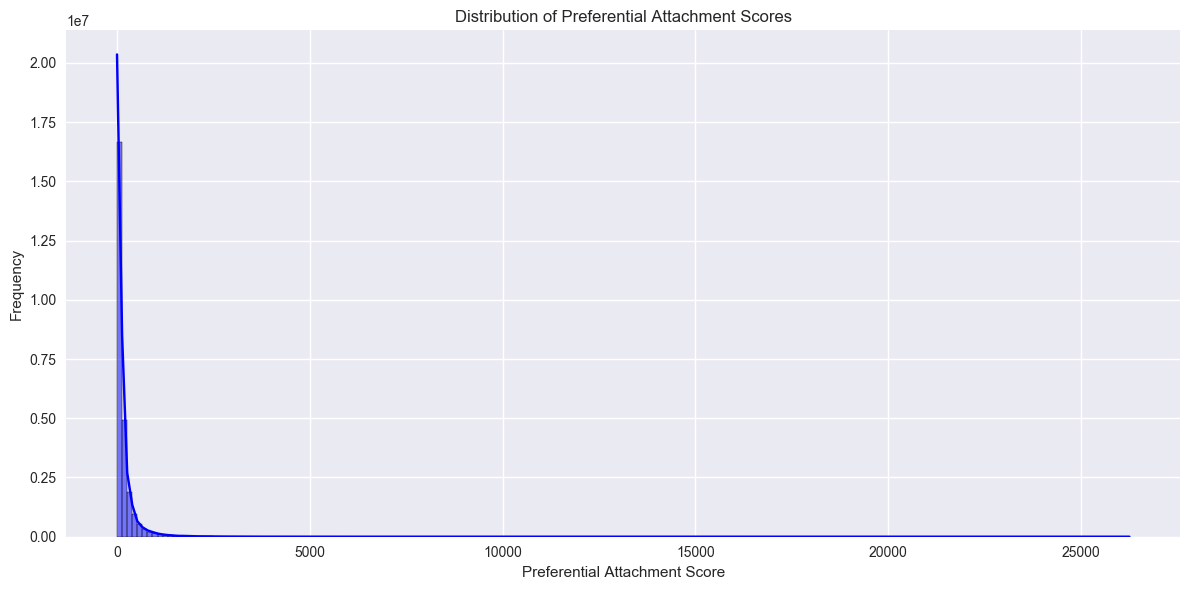

In [65]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Create histogram
sns.histplot(pa_df['Score'], bins=200, kde=True, color='blue')

# Add titles and labels
plt.title('Distribution of Preferential Attachment Scores')
plt.xlabel('Preferential Attachment Score')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()
